In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [231]:
#load data_tanque.csv
data_tanque = pd.read_csv('../datos estanque/datos sin falla/25s/train_2_st25s.csv', names = ['tiempo', 'referencia', 'hc', 'f_pid'], low_memory= False)[1:].reset_index(drop=True)

data_tanque.head()

tiempo  referencia   hc  f_pid
0       1          40  0.0    0.0
1       2          40  0.0    0.0
2       3          40  0.0    0.0
3       4          40  0.0    0.0
4       5          40  0.0    0.0

In [232]:
#sample data linearly by 2 rows till 20000 rows
df = data_tanque.copy()
sampling_time = 25
df = df[::sampling_time][3:]

In [4]:
df.head(10)

tiempo  referencia         hc       f_pid
75       76          40  43.504907   39.811401
100     101          40  41.344126    0.000000
125     126          40  41.301097    0.000000
150     151          40  39.268629    0.000000
175     176          40  36.906444   13.158117
200     201          40  34.391488   55.383895
225     226          40  31.667652  100.000000
250     251          40  34.368059  100.000000
275     276          40  40.642301  100.000000
300     301          40  45.566709    0.000000

Text(0.5, 1.0, 'referencia y hc en funcion del tiempo')

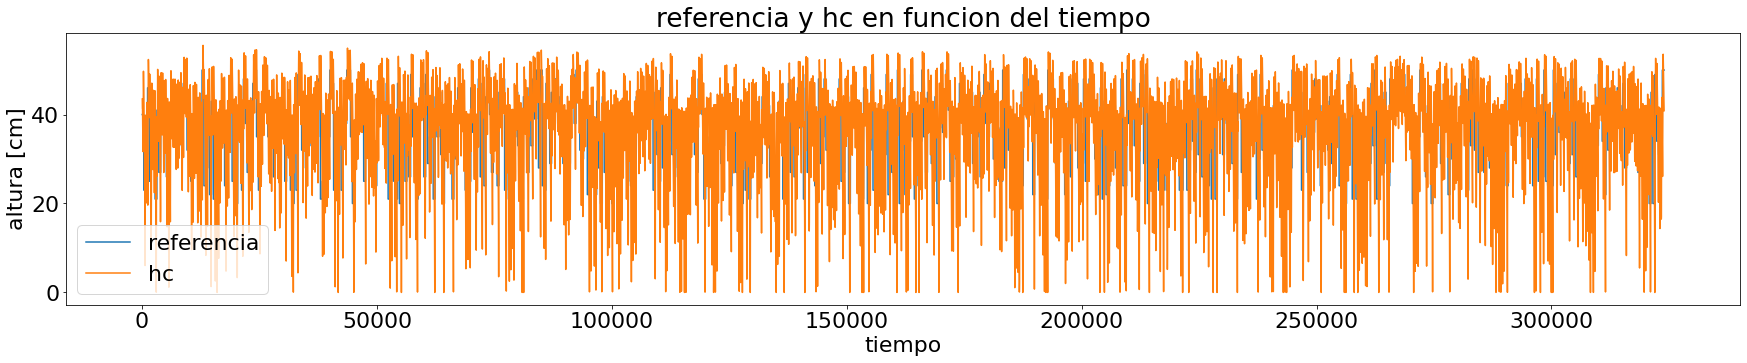

In [436]:
#graficar los referencia y hc en funcion del tiempo
plt.figure(figsize=(30,5))
plt.plot(df['tiempo'], df['referencia'], label='referencia')
plt.plot(df['tiempo'], df['hc'], label='hc')
plt.legend()
plt.xlabel('tiempo')
plt.ylabel('altura [cm]')
plt.title('referencia y hc en funcion del tiempo')

(0.0, 3600.0)

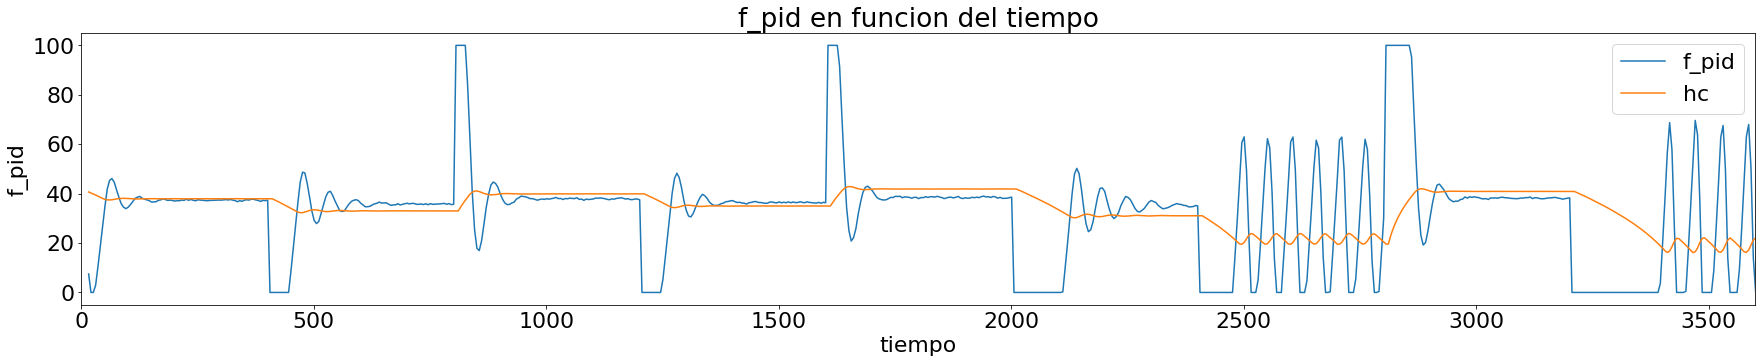

In [376]:
#plot f_pid
plt.figure(figsize=(30,5))
plt.plot(df['tiempo'], df['f_pid'], label='f_pid')
plt.plot(df['tiempo'], df['hc'], label='hc')
plt.legend()
plt.xlabel('tiempo')
plt.ylabel('f_pid')
plt.title('f_pid en funcion del tiempo')
plt.xlim(0, 3600)

# RED MLP

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.cuda.is_available() 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
df['hc'].shift(1).diff(1).to_numpy()

array([        nan,         nan, -2.16078096, ..., -2.05633125,
       -1.82638574, -2.00781277])

In [ ]:
#train set: 12 hours
step = int(89*3600/sampling_time)

X_train = torch.from_numpy(np.vstack(((df['hc'].shift(1).to_numpy()[3:step],
                                     df['f_pid'].shift(1).to_numpy()[3:step],

                                     df['hc'].shift(2).to_numpy()[3:step],
                                     df['f_pid'].shift(2).to_numpy()[3:step],
                                     
                                    #  df['hc'].shift(3).to_numpy()[3:step],
                                    #  df['f_pid'].shift(3).to_numpy()[3:step],

                                    #  df['hc'].shift(3).to_numpy()[3:step],
                                    #  df['f_pid'].shift(3).to_numpy()[3:step]
                                    ))).T).float()


y_train = torch.from_numpy(((df['hc'].to_numpy()[3:step]))).float()


#create validation data since 12 hours to the end:

X_valid = torch.from_numpy(np.vstack(((df['hc'].shift(1).to_numpy()[step:],
                                     df['f_pid'].shift(1).to_numpy()[step:],

                                     df['hc'].shift(2).to_numpy()[step:],
                                     df['f_pid'].shift(2).to_numpy()[step:],

                                    #  df['hc'].shift(3).to_numpy()[step:],
                                    #  df['f_pid'].shift(3).to_numpy()[step:]
                                     ))).T).float()
                                      
y_valid = torch.from_numpy(((df['hc'].to_numpy()[step:]))).float()


#test data
data_tanque = pd.read_csv('../datos estanque/datos sin falla/25s/test_st25s.csv',names = ['tiempo', 'referencia', 'hc', 'f_pid'], low_memory= False)[1:].reset_index(drop=True)
data_tanque.head()
df_test = data_tanque.copy()
sampling_time = 25
df_test = df_test[::sampling_time][3:]

#DEfine X_test and y_test
X_test = torch.from_numpy(np.vstack(((df_test['hc'].shift(1).to_numpy()[3:],
                                     df_test['f_pid'].shift(1).to_numpy()[3:],

                                     df_test['hc'].shift(2).to_numpy()[3:],
                                     df_test['f_pid'].shift(2).to_numpy()[3:],

                                    #  df_test['hc'].shift(3).to_numpy()[3:],
                                    #  df_test['f_pid'].shift(3).to_numpy()[3:]
                                     ))).T).float()
X_test = X_test.to(device)
y_test = torch.from_numpy(((df_test['hc'].to_numpy()[3:]))).float()
y_test = y_test.to(device)



In [261]:
#train set:
step = int(89*3600/sampling_time)

X_train = torch.from_numpy(np.vstack(((df['hc'].shift(1).to_numpy()[3:step],
                                     df['f_pid'].shift(1).to_numpy()[3:step],

                                     df['hc'].shift(2).to_numpy()[3:step],
                                     df['f_pid'].shift(2).to_numpy()[3:step],
                                    ))).T).float()


y_train = torch.from_numpy(((df['hc'].to_numpy()[3:step]))).float()


#validation set as the rest of the data:

X_valid = torch.from_numpy(np.vstack(((df['hc'].shift(1).to_numpy()[step:],
                                     df['f_pid'].shift(1).to_numpy()[step:],

                                     df['hc'].shift(2).to_numpy()[step:],
                                     df['f_pid'].shift(2).to_numpy()[step:],
                                     ))).T).float()
                                      
y_valid = torch.from_numpy(((df['hc'].to_numpy()[step:]))).float()


#test data
data_tanque = pd.read_csv('../datos estanque/datos sin falla/25s/test_st25s.csv',names = ['tiempo', 'referencia', 'hc', 'f_pid'], low_memory= False)[1:].reset_index(drop=True)
data_tanque.head()
df_test = data_tanque.copy()
sampling_time = 25
df_test = df_test[::sampling_time][3:]

#DEfine X_test and y_test
X_test = torch.from_numpy(np.vstack(((df_test['hc'].shift(1).to_numpy()[3:],
                                     df_test['f_pid'].shift(1).to_numpy()[3:],

                                     df_test['hc'].shift(2).to_numpy()[3:],
                                     df_test['f_pid'].shift(2).to_numpy()[3:],
                                     ))).T).float()
X_test = X_test.to(device)
y_test = torch.from_numpy(((df_test['hc'].to_numpy()[3:]))).float()
y_test = y_test.to(device)



In [234]:
#naive prediction
from sklearn.metrics import mean_squared_error
y_pred_naive = (df_test['hc'].shift(1)[1:].values)
#replace nans by 0
y_pred_naive[np.isnan(y_pred_naive)] = 0
naive_loss = mean_squared_error((df_test['hc'][1:].values), y_pred_naive)
naive_loss

23.195174701844827

Text(0.5, 1.0, 'actual_y and y_pred_naive')

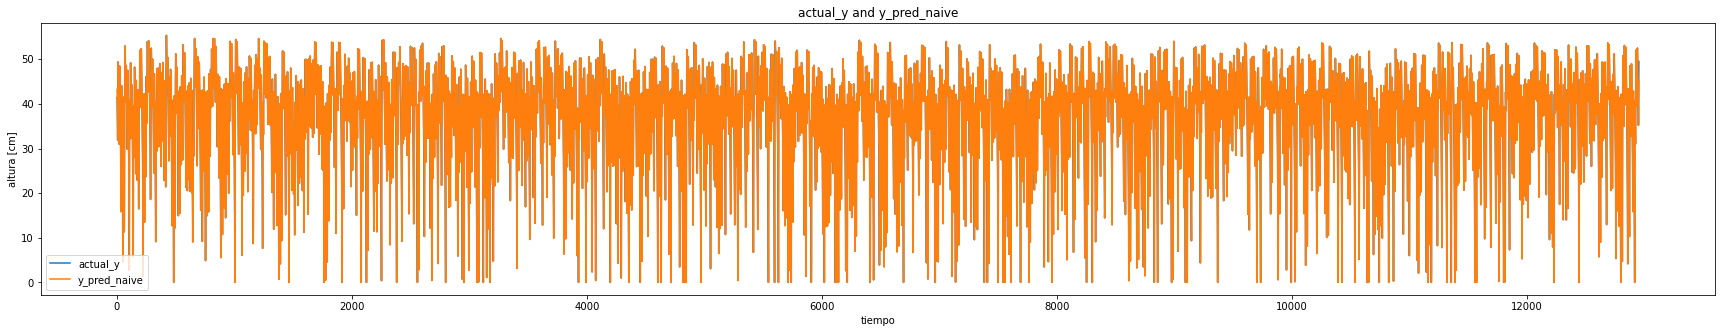

In [8]:
#plot (df_test['hc'][1:].values) and y_pred_naive
actual_y = (df_test['hc'][1:].values)
plt.figure(figsize=(30,5))
plt.plot(actual_y, label='actual_y')
plt.plot(y_pred_naive, label='y_pred_naive')
plt.legend()
plt.xlabel('tiempo')
plt.ylabel('altura [cm]')
plt.title('actual_y and y_pred_naive')


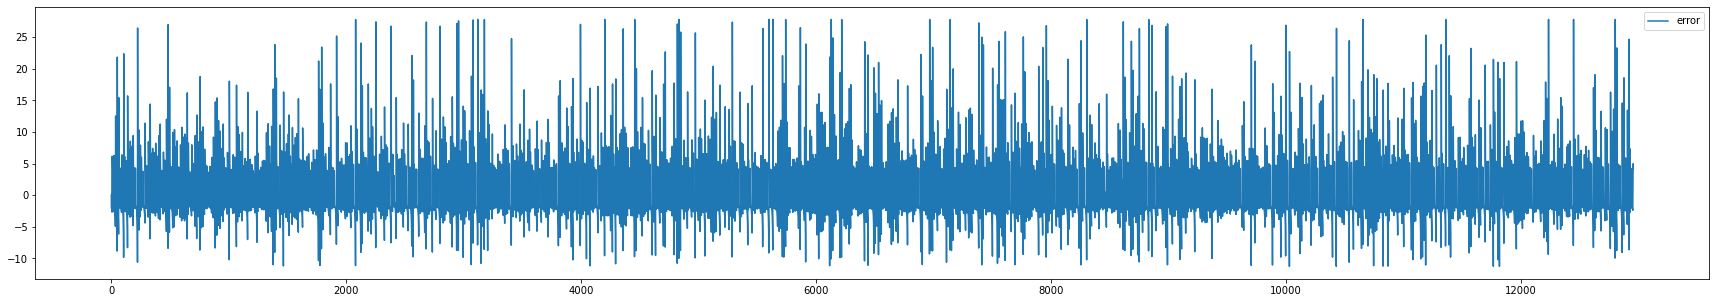

In [10]:
#plot the error
plt.figure(figsize=(30,5))
plt.plot(actual_y - y_pred_naive, label='error')
plt.legend()

In [262]:
X_train = X_train.to(device)
y_train = y_train.to(device)
X_valid = X_valid.to(device)
y_valid = y_valid.to(device)

In [236]:
class MLP2(nn.Module):
    def __init__(self):
        super(MLP2, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 200),
            nn.ReLU(),
            nn.Linear(200, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
            nn.ReLU(),
            nn.Linear(10, 1),
            nn.ReLU(),
            
        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [13]:
class MLP3(nn.Module):
    def __init__(self):
        super(MLP3, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(4, 100),
            nn.ReLU(),
            nn.Linear(100, 25),
            nn.ReLU(),
            nn.Linear(25, 10),
            nn.ReLU(),
            nn.Linear(10, 1),
            nn.ReLU(),
            
        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [237]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(4, 200),
            nn.ReLU(),
            nn.Linear(200, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
            nn.ReLU(),
            nn.Linear(10, 1),
            nn.ReLU(),
            
        )

    def forward(self, x):
        x = self.layers(x)
        return x
    

In [266]:
#cross validation
from sklearn.model_selection import KFold
model = MLP()

model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
loss_fn = nn.MSELoss()


loss_curve_train =[naive_loss*0.09]#[np.inf]#[np.inf]# [0.0005]#
loss_curve_valid =[naive_loss*0.09]#.[np.inf]# [np.inf]#[0.0005]#
saved_i = 0
epochs = 10000
nsplits = 5
kfold = KFold(n_splits=nsplits, shuffle=True)

for epoch in range(epochs):
    mean_loss_val = 0
    mean_loss_train = 0
    for train_index, valid_index in kfold.split(X_train):
        X_train_cv, X_valid_cv = X_train[train_index], X_train[valid_index]
        y_train_cv, y_valid_cv = y_train[train_index], y_train[valid_index]

        model.train()
        y_pred = model(X_train_cv)
        loss = loss_fn(y_pred.squeeze(), y_train_cv)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #validation
        model.eval()
        with torch.no_grad():
            y_pred_val = model(X_valid_cv)
            
            loss_val = loss_fn(y_pred_val.squeeze(), y_valid_cv)
            
            mean_loss_val += loss_val.item()
            
            mean_loss_train += loss.item()

    mean_loss_val = mean_loss_val/nsplits
    mean_loss_train = mean_loss_train/nsplits

    loss_curve_train.append(mean_loss_train)
    loss_curve_valid.append(mean_loss_val)

    # save best model
    if mean_loss_train <= min(loss_curve_train) and (mean_loss_val <= min(loss_curve_train) or mean_loss_val <= min(loss_curve_valid)):
        print('saving model...')
        saved_i = epoch
        torch.save(model.state_dict(), '../modelos torch/st25s_m.pth')
        print('Model saved')
    # loss_curve_train.append(loss.item())
    # loss_curve_valid.append(loss_val.item())
    print('Epoch: {}, Loss validation: {:.4f}, Loss train: {:.4f}'.format(epoch, mean_loss_val, mean_loss_train))
print(f'last epoch saved {saved_i}')

Epoch: 0, Loss validation: 1365.8148, Loss train: 1368.3956
Epoch: 1, Loss validation: 1352.7121, Loss train: 1355.3657
Epoch: 2, Loss validation: 1339.0541, Loss train: 1341.8657
Epoch: 3, Loss validation: 1324.7991, Loss train: 1327.6355
Epoch: 4, Loss validation: 1310.2329, Loss train: 1313.1554
Epoch: 5, Loss validation: 1295.4170, Loss train: 1298.3844
Epoch: 6, Loss validation: 1280.3467, Loss train: 1283.3508
Epoch: 7, Loss validation: 1264.7328, Loss train: 1267.9360
Epoch: 8, Loss validation: 1248.6665, Loss train: 1251.9253
Epoch: 9, Loss validation: 1232.3867, Loss train: 1235.6845
Epoch: 10, Loss validation: 1215.5618, Loss train: 1218.9563
Epoch: 11, Loss validation: 1198.2724, Loss train: 1201.7384
Epoch: 12, Loss validation: 1180.7275, Loss train: 1184.2744
Epoch: 13, Loss validation: 1163.1075, Loss train: 1166.6467
Epoch: 14, Loss validation: 1145.5497, Loss train: 1149.0846
Epoch: 15, Loss validation: 1127.9024, Loss train: 1131.5011
Epoch: 16, Loss validation: 1110.1

KeyboardInterrupt: 

In [243]:
loss_curve_train[saved_i]


0.019175444170832633

In [244]:
loss_curve_valid[saved_i]

0.01915188431739807

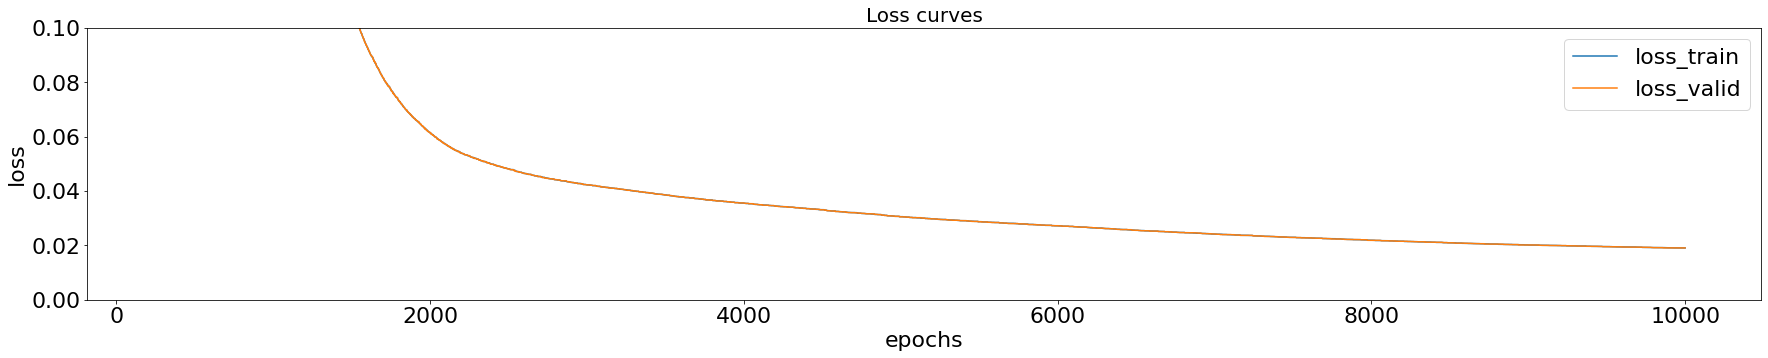

In [248]:
#plot loss curves (lmao what a noisy curves lol)


plt.figure(figsize=(30,5))
plt.plot(pd.Series(loss_curve_train[:]).rolling(300).min(), label='loss_train')
plt.plot(pd.Series(loss_curve_valid[:]).rolling(300).min(), label='loss_valid')
plt.xlabel('epochs')
plt.ylabel('loss')

# plt.xlim(150, 1000)
# plt.ylim(0, 0.04)
#increment font size and legend size
plt.legend(fontsize=20)
plt.title('Loss curves', fontsize=20)
plt.rcParams.update({'font.size': 22})
plt.ylim(0,0.1)
plt.legend()

In [44]:
#create a rnn model with the same parameters
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(4, 200, 1, batch_first=True)
        self.fc = nn.Linear(200, 1)
        
    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.fc(x[:, -1, :])
        return x
        

In [139]:
#train model with early stopping
model = MLP2()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
loss_fn = nn.MSELoss()
loss_curve_train = [np.inf]
loss_curve_valid = [np.inf]
epochs = 20000
for epoch in range(epochs):
    model.train()
    y_pred = model(X_train.unsqueeze(1))
    loss = loss_fn(y_pred.squeeze(), y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #validation

    y_pred_val = model(X_valid.unsqueeze(1))
    loss_val = loss_fn(y_pred_val.squeeze(), y_valid)

    # save best model
    if loss.item() < min(loss_curve_train): #and loss_val.item() < min(loss_curve_valid):
        print('saving model...')
        torch.save(model.state_dict(), '../modelos torch/25s_overfitted.pt')
        print('Model saved')
    
    loss_curve_train.append(loss.item())
    loss_curve_valid.append(loss_val.item())

    print('Epoch: {}, Loss validation: {:.4f}, Loss train: {:.4f}'.format(epoch, loss_val.item(), loss.item() ))

saving model...
Model saved
Epoch: 0, Loss validation: 1388.5551, Loss train: 1444.8232
saving model...
Model saved
Epoch: 1, Loss validation: 1379.7400, Loss train: 1435.7991
saving model...
Model saved
Epoch: 2, Loss validation: 1370.6758, Loss train: 1426.6334
saving model...
Model saved
Epoch: 3, Loss validation: 1361.2635, Loss train: 1417.2095
saving model...
Model saved
Epoch: 4, Loss validation: 1351.5095, Loss train: 1407.4811
saving model...
Model saved
Epoch: 5, Loss validation: 1341.3809, Loss train: 1397.4205
saving model...
Model saved
Epoch: 6, Loss validation: 1331.1379, Loss train: 1386.9580
saving model...
Model saved
Epoch: 7, Loss validation: 1320.8226, Loss train: 1376.3553
saving model...
Model saved
Epoch: 8, Loss validation: 1310.5056, Loss train: 1365.6698
saving model...
Model saved
Epoch: 9, Loss validation: 1300.1920, Loss train: 1354.9819
saving model...
Model saved
Epoch: 10, Loss validation: 1289.9135, Loss train: 1344.3026
saving model...
Model saved
Epo

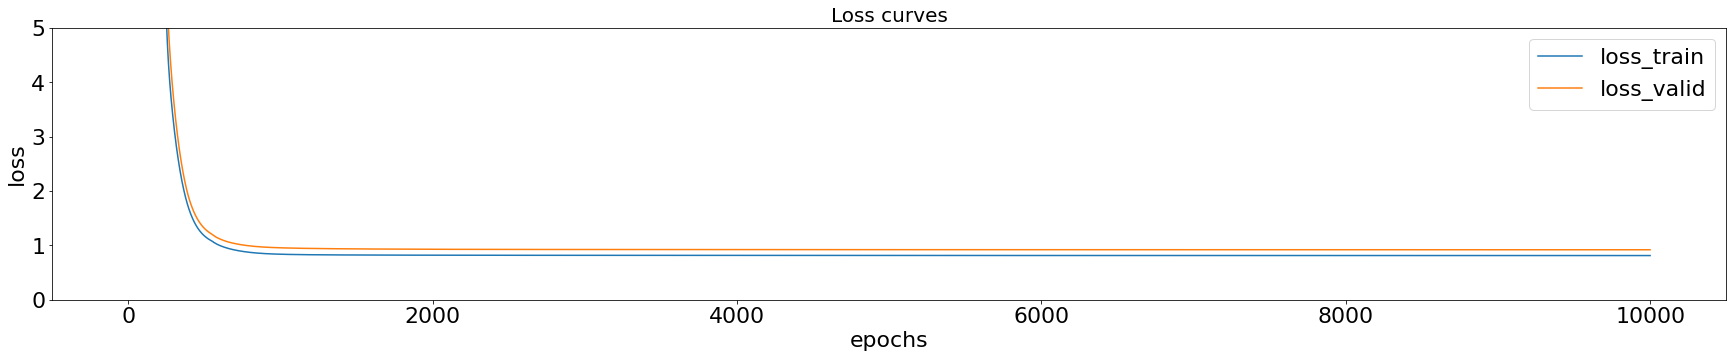

In [140]:
#plot loss curves (lmao what a noisy curves lol)


plt.figure(figsize=(30,5))
plt.plot(loss_curve_train[:], label='loss_train')
plt.plot(loss_curve_valid[:], label='loss_valid')
plt.xlabel('epochs')
plt.ylabel('loss')

# plt.xlim(150, 1000)
# plt.ylim(0, 0.04)
#increment font size and legend size
plt.legend(fontsize=20)
plt.title('Loss curves', fontsize=20)
plt.rcParams.update({'font.size': 22})
#limit y between 0 to 1
plt.ylim(0,5)

plt.legend()

(0.0, 50.0)

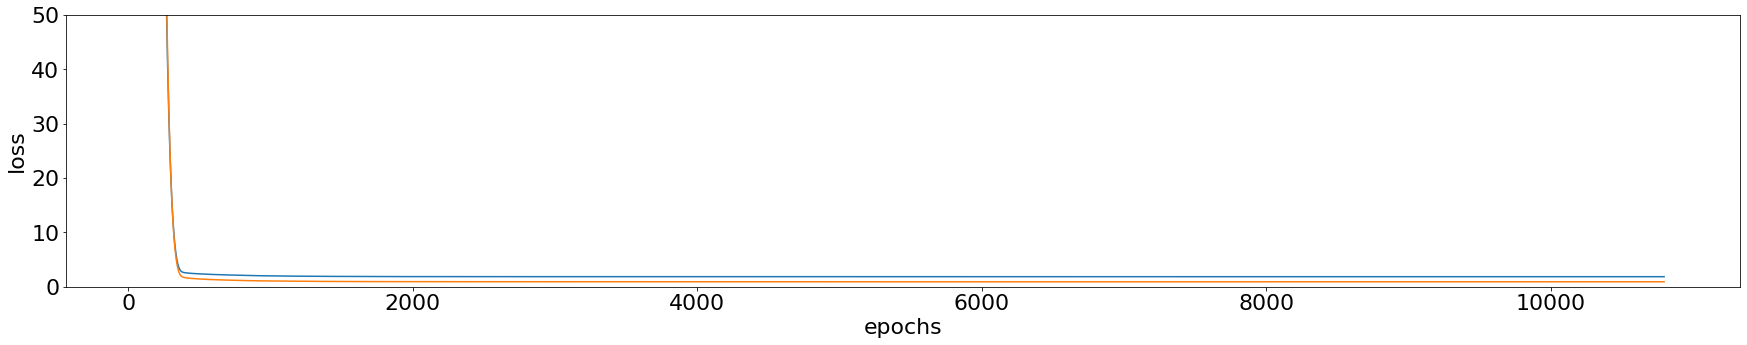

In [124]:
#suavizar curvas 
plt.figure(figsize=(30,5))
plt.plot(pd.Series(loss_curve_train[:]).rolling(100).mean(), label='loss_train')
plt.plot(pd.Series(loss_curve_valid[:]).rolling(100).mean(), label='loss_valid')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0,50)



In [249]:
#load model
model = MLP()
model.load_state_dict(torch.load('../modelos torch/st25s_m.pth'))
model.to(device)


MLP(
  (layers): Sequential(
    (0): Linear(in_features=4, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=1, bias=True)
    (7): ReLU()
  )
)

In [250]:
#test model
model.eval()
y_pred_gpu = model(X_test)
#to cpu
y_pred = y_pred_gpu.cpu().detach().numpy()
y_test = y_test.cpu().detach().numpy()

loss = mean_squared_error(y_pred[2:], y_test[2:])
print('Loss test: {:.4f}'.format(loss.item()))


Loss test: 0.0245


(2840.0, 2920.0)

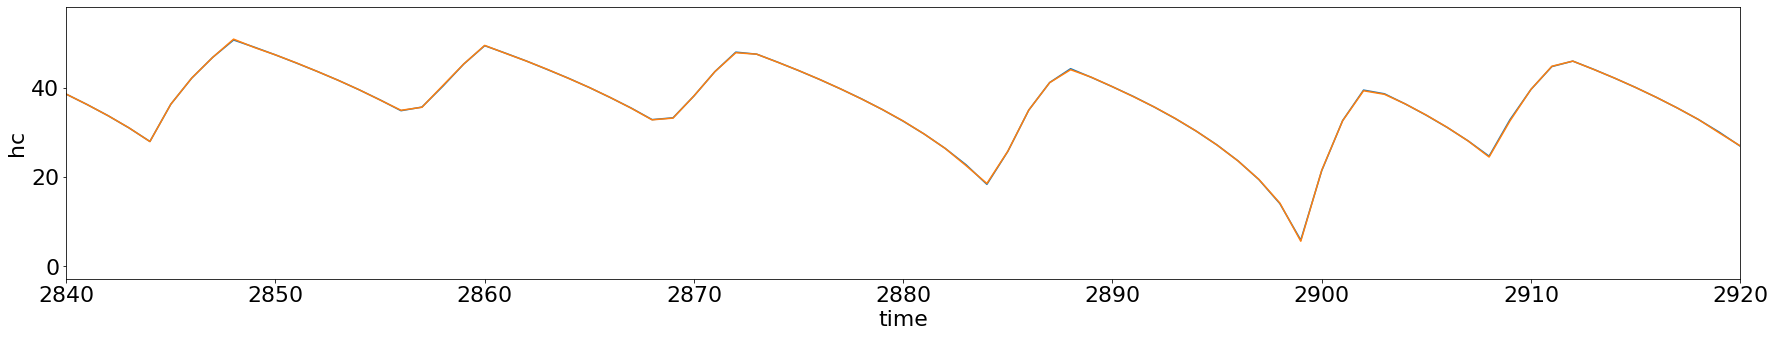

In [251]:
#plot y_test and y_pred
#to cpu
# y_pred = y_pred.cpu().detach().numpy()
# y_test = y_test.cpu().detach().numpy()

plt.figure(figsize=(30,5))
plt.plot(y_test, label='y_test')
plt.plot(y_pred, label='y_pred')
plt.xlabel('time')
plt.ylabel('hc')
plt.xlim(71000/25, 73000/25)

In [324]:

noise_order = '10m1'
sampling_time = 5
d = {
        0: f'{noise_order}_1a_st{sampling_time}s.csv',
        1: f'{noise_order}_1b_st{sampling_time}s.csv',
        2: f'{noise_order}_5a_st{sampling_time}s.csv',
        3: f'{noise_order}_5b_st{sampling_time}s.csv',
        4: f'{noise_order}_10a_st{sampling_time}s.csv',
        5: f'{noise_order}_10b_st{sampling_time}s.csv',
  }

In [403]:
45*3600

162000

In [257]:
n_o = '10m4'
s_t = 25
df_father = pd.read_csv(f'../datos estanque/datos con falla/{s_t}s/{n_o}/{n_o}_10a_st{s_t}s.csv', names = ['tiempo', 'referencia', 'hc', 'f_pid'], low_memory= False)[1:].reset_index(drop=True)[::s_t]

#make 12 df_sons adding gaussian noise (0, 0.001) to the father, maximum 4 decimals
df_sons = {}
for i in range(12):
    df_sons[i] = df_father.copy()
    df_sons[i]['hc'] = df_sons[i]['hc'].apply(lambda x: round(x + np.random.normal(0, 0.01), 4))
    #to numeric
    df_sons[i] = df_sons[i].apply(pd.to_numeric)
    df_sons[i].to_csv(f'../datos estanque/datos con falla/sons/{n_o}_son{i+1}_10a_st{s_t}s.csv', index=False)



In [ ]:
df_

In [260]:
#apply model to df_sons
model = MLP()
model.load_state_dict(torch.load('../modelos torch/st25s_m.pth'))
model.to(device)

#test model
model.eval()
for i in range(12):
    df = pd.read_csv(f'../datos estanque/datos con falla/{s_t}s/{n_o}/{n_o}_son{i+1}_10a_st{s_t}s.csv').apply(pd.to_numeric)
    X_test = torch.from_numpy(np.vstack(((df['hc'].shift(1).to_numpy()[2:],
                                         df['f_pid'].shift(1).to_numpy()[2:],
                                         df['hc'].shift(2).to_numpy()[2:],
                                         df['f_pid'].shift(2).to_numpy()[2:],
                                        #  df['hc'].shift(3).to_numpy()[2:],
                                        #  df['f_pid'].shift(3).to_numpy()[2:],
                                         ))).T).float()
    X_test = X_test.to(device)
    y_pred_gpu = model(X_test.unsqueeze(1))
    #to cpu
    y_pred = y_pred_gpu.cpu().detach().numpy()
    y_pred = y_pred.reshape(len(y_pred))
    y_test = torch.from_numpy(((df['hc'].to_numpy()[2:]))).float()
    loss = mean_squared_error(y_pred[2:], y_test[2:])
    print(f'Loss test son{i+1}: {loss}')

    df_export = df[:][2:].copy()
    df_export['y_hat'] = y_pred
    df_export.to_csv(f'../outputs modelo/sons/25s_10m3_10a_{i}.csv', index=False)

Loss test son1: 0.14250139892101288
Loss test son2: 0.14255113899707794
Loss test son3: 0.1425502747297287
Loss test son4: 0.142656147480011
Loss test son5: 0.14258718490600586
Loss test son6: 0.14255379140377045
Loss test son7: 0.14263811707496643
Loss test son8: 0.14254982769489288
Loss test son9: 0.14254751801490784
Loss test son10: 0.14263394474983215
Loss test son11: 0.142639622092247
Loss test son12: 0.14250397682189941


In [218]:
y_pred.reshape(len(y_pred))

array([ 0.      ,  0.      ,  0.      , ..., 47.814438, 47.814438,
       47.814438], dtype=float32)

In [155]:
df_father

tiempo  referencia         hc       f_pid
0            1          40   0.000000    0.000000
1            2          40   0.000000    0.000000
2            3          40   0.000000    0.000000
3            4          40   0.000000    0.000000
4            5          40  40.000001  100.000000
...        ...         ...        ...         ...
323995  323996          45  43.677933   42.680940
323996  323997          45  43.677933   42.680940
323997  323998          45  43.677933   42.680940
323998  323999          45  43.677933   42.680940
323999  324000          22  43.679338   42.934208

[324000 rows x 4 columns]

In [177]:
df_son['tiempo'].apply(pd.to_numeric)[0:1000]

0         1
1         2
2         3
3         4
4         5
       ... 
995     996
996     997
997     998
998     999
999    1000
Name: tiempo, Length: 1000, dtype: int64

Text(0, 0.5, 'hc')

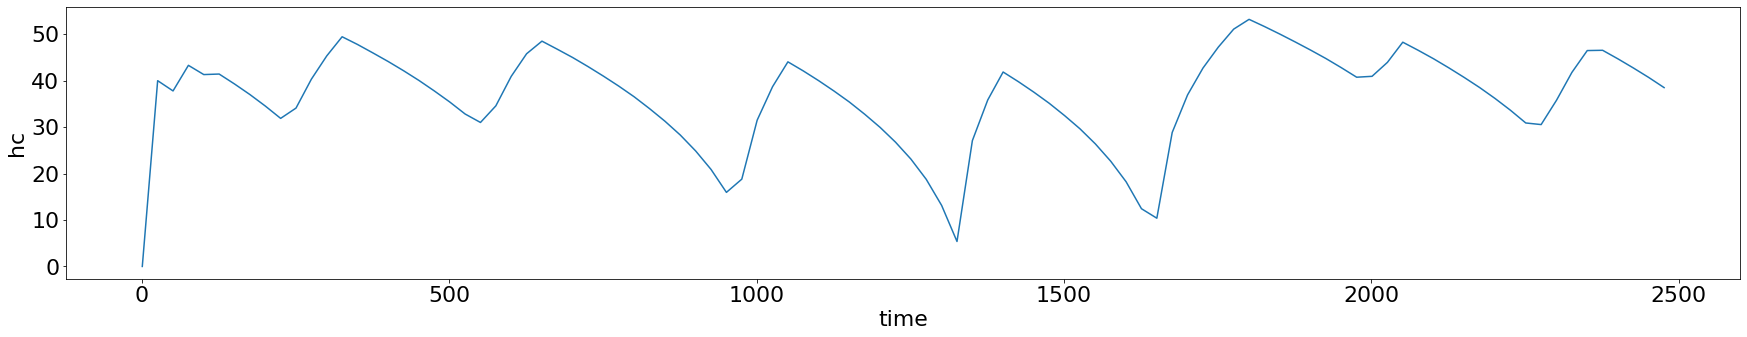

In [229]:
#plot a random df_son
# df_son = pd.read_csv(f'../datos estanque/datos con falla/{s_t}s/{n_o}/{n_o}_son1_10a_st{s_t}s.csv', names = ['tiempo', 'referencia', 'hc', 'f_pid'], low_memory= False)[1:].reset_index(drop=True).apply(pd.to_numeric)
plt.figure(figsize=(30,5))
plt.plot(df_son['tiempo'][:100],df_son['hc'][:100], label='hc')
plt.xlabel('time')
plt.ylabel('hc')


In [ ]:
#

Text(0.5, 0, 'time')

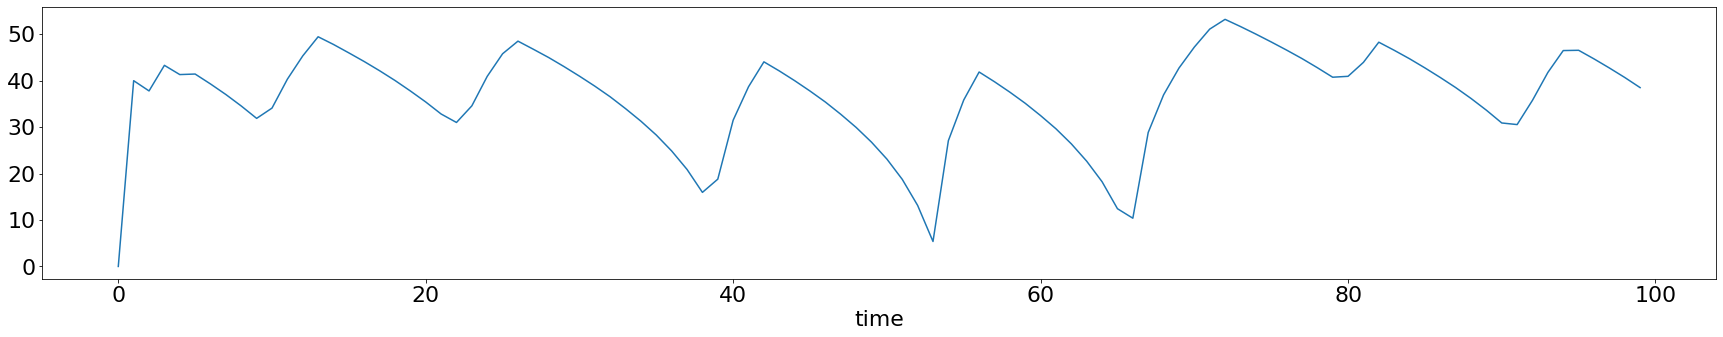

In [226]:
#plot df_son['hc]
plt.figure(figsize=(30,5))
plt.plot(df_son['hc'][0:100], label='hc')
plt.xlabel('time')

In [424]:
noise_order = ['10m4','10m3','10m2','10m1']
sampling_time = 25
d_2 = {
        0: f'{noise_order[0]}_1b_st{sampling_time}s.csv',
        1: f'{noise_order[1]}_1b_st{sampling_time}s.csv',
        2: f'{noise_order[2]}_1b_st{sampling_time}s.csv',
        3: f'{noise_order[3]}_1b_st{sampling_time}s.csv',
  }

for i in range(4):

    data_tanque = pd.read_csv(f'../datos estanque/datos con falla/{sampling_time}s/{noise_order[i]}/{d_2[i]}', names = ['tiempo', 'referencia', 'hc', 'f_pid'], low_memory= False)[1:].reset_index(drop=True)
    #get half of the dataset
    
    df = data_tanque.copy()[:161000]
    df = df[::sampling_time][3:]
    step = 2
    X_test = torch.from_numpy(np.vstack(((df['hc'].shift(1).to_numpy()[2:],
                                         df['f_pid'].shift(1).to_numpy()[2:],
                                         df['hc'].shift(2).to_numpy()[2:],
                                         df['f_pid'].shift(2).to_numpy()[2:],
                                        #  df['hc'].shift(3).to_numpy()[2:],
                                        #  df['f_pid'].shift(3).to_numpy()[2:],
                                         ))).T).float()
    X_test = X_test.to(device)
    y_test = torch.from_numpy(((df['hc'].to_numpy()[2:]))).float()
    y_test = y_test.to(device)

    #calc y_hat
    y_hat = model(X_test)
    #to cpu
    y_hat = y_hat.cpu()

    #deatch
    y_hat = y_hat.detach().numpy()

    y_hat_naive = df['hc'].shift(1).to_numpy()[2:]
    #filter nans
    y_hat_naive[np.isnan(y_hat_naive)]  = 0
    
    naive_mse = mean_squared_error(y_hat_naive, y_test.cpu().detach().numpy())

    #flat
    y_hat = y_hat.flatten()
    #print naive mse and actual mse
    print(f'---------------- {noise_order[i]} ------------------')
    print(f'naive mse: {naive_mse}')
    print(f'actual mse: {mean_squared_error(y_hat, y_test.cpu().detach().numpy())}')
    print('\n')
    


---------------- 10m4 ------------------
naive mse: 2.338259186402975
actual mse: 0.004550096113234758


---------------- 10m3 ------------------
naive mse: 2.341190850562083
actual mse: 0.006061375141143799


---------------- 10m2 ------------------
naive mse: 2.360869028036423
actual mse: 0.023396961390972137


---------------- 10m1 ------------------
naive mse: 2.554184251587266
actual mse: 0.1955857276916504




In [39]:
# test on another set... same as previous

noise_order = '10m4'
sampling_time = 25
d = {
        0: f'{noise_order}_1a_st{sampling_time}s.csv',
        1: f'{noise_order}_1b_st{sampling_time}s.csv',
        2: f'{noise_order}_5a_st{sampling_time}s.csv',
        3: f'{noise_order}_5b_st{sampling_time}s.csv',
        4: f'{noise_order}_10a_st{sampling_time}s.csv',
        5: f'{noise_order}_10b_st{sampling_time}s.csv',
  }

for i in range(6):

    data_tanque = pd.read_csv(f'../datos estanque/datos con falla/{sampling_time}s/{noise_order}/{d[i]}', names = ['tiempo', 'referencia', 'hc', 'f_pid'], low_memory= False)[1:].reset_index(drop=True)
    data_tanque.head()
    df = data_tanque.copy()
    df = df[::sampling_time][3:]
    step = 2
    X_test = torch.from_numpy(np.vstack(((df['hc'].shift(1).to_numpy()[2:],
                                         df['f_pid'].shift(1).to_numpy()[2:],
                                         df['hc'].shift(2).to_numpy()[2:],
                                         df['f_pid'].shift(2).to_numpy()[2:],
                                        #  df['hc'].shift(3).to_numpy()[2:],
                                        #  df['f_pid'].shift(3).to_numpy()[2:],
                                         ))).T).float()
    X_test = X_test.to(device)
    y_test = torch.from_numpy(((df['hc'].to_numpy()[2:]))).float()
    y_test = y_test.to(device)

    #calc y_hat
    y_hat = model(X_test)
    #to cpu
    y_hat = y_hat.cpu()

    #deatch
    y_hat = y_hat.detach().numpy()

    #flat
    y_hat = y_hat.flatten()

    # #export csv with y_hat
    df_export = df[:][2:].copy()
    df_export['y_hat'] = y_hat
    df_export.to_csv(f'../outputs modelo/ultimate/st{sampling_time}s/{noise_order}/1pred_{d[i]}', index=False)


In [393]:

data_tanque = pd.read_csv(f'../datos estanque/datos con falla/{sampling_time}s/{noise_order}/{d[0]}', names = ['tiempo', 'referencia', 'hc', 'f_pid'], low_memory= False)[1:].reset_index(drop=True)
data_tanque.head()
df = data_tanque.copy()
df = df[::sampling_time][3:]
step = 2
X_test = torch.from_numpy(np.vstack(((df['hc'].shift(1).to_numpy()[2:],
                                     df['f_pid'].shift(1).to_numpy()[2:],
                                     df['hc'].shift(2).to_numpy()[2:],
                                     df['f_pid'].shift(2).to_numpy()[2:],
                                    #  df['hc'].shift(3).to_numpy()[2:],
                                    #  df['f_pid'].shift(3).to_numpy()[2:],
                                     ))).T).float()
X_test = X_test.to(device)
y_test = torch.from_numpy(((df['hc'].to_numpy()[2:]))).float()
y_test = y_test.to(device)
#calc y_hat
y_hat = model(X_test)
#to cpu
y_hat = y_hat.cpu()
#deatch
y_hat = y_hat.detach().numpy()
#flat
y_hat = y_hat.flatten()

df_exported = df[:][2:].copy()
df_exported['y_hat'] = y_hat


In [333]:
#calc y_hat
y_hat = model(X_test)
#to cpu
y_hat = y_hat.cpu()

#deatch
y_hat = y_hat.detach().numpy()

#flat
y_hat = y_hat.flatten()


In [394]:

df_exported = pd.read_csv(f'../outputs modelo/ultimate/st1s/10m3/pred_10m3_10a_st1s.csv')

In [391]:
df_exported

tiempo  referencia         hc      f_pid      y_hat
0            6          40  39.827299   1.299554  39.825302
1            7          40  39.664506   3.090813  39.744556
2            8          40  39.628010   6.000746  39.606857
3            9          40  39.491507   6.653140  39.499380
4           10          40  39.485529   9.093172  39.406628
...        ...         ...        ...        ...        ...
323990  323996          45  43.678449  43.091331  43.749817
323991  323997          45  43.688131  43.959909  43.721817
323992  323998          45  43.698730  43.786973  43.704945
323993  323999          45  43.760202  43.597640  43.721584
323994  324000          22  43.733071   0.000000  43.758410

[323995 rows x 5 columns]

Text(0.5, 0, 'time')

<Figure size 2160x360 with 0 Axes>

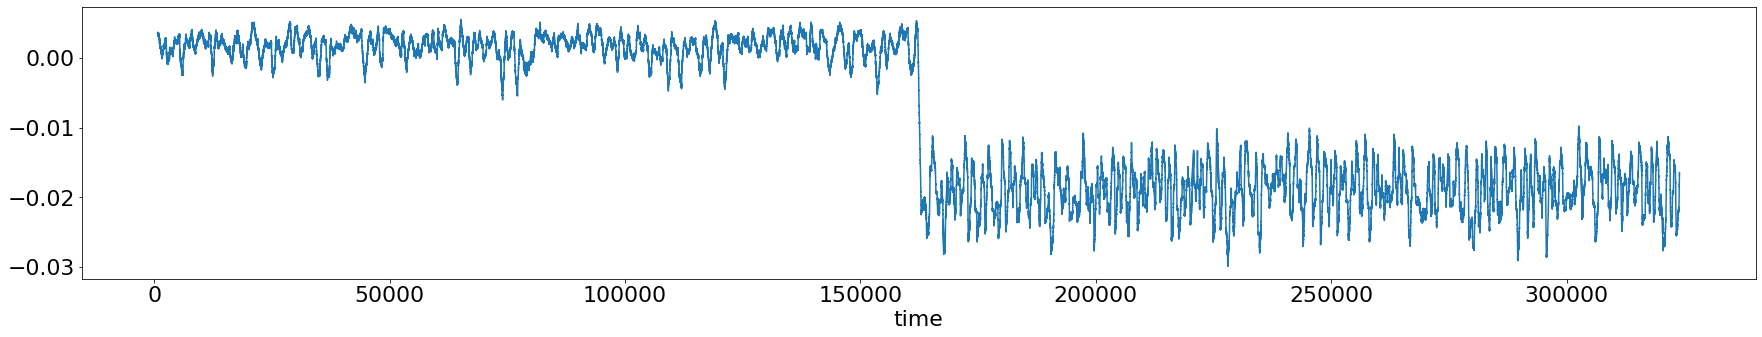

In [395]:
#plot the residual

plt.figure(figsize=(30,5))
plt.figure(figsize=(30,5))
plt.plot((df_exported['hc'] - df_exported['y_hat']).rolling(720).mean(), label='residual')
plt.xlabel('time')

In [270]:
y_hat = df_exported['y_hat']
y_test = df_exported['hc']


In [272]:
#calculate mse
mean_squared_error(y_hat[1:3600], y_test[1:3600])


0.0018815788477846865

In [273]:
#calculate mse
mean_squared_error(y_hat[-3600:-1], y_test[-3600:-1])


0.0022717652711725313

In [834]:
# # #export csv with y_hat
# df_export = df[:][2:].copy()
# df_export['y_hat'] = y_hat
# df_export.to_csv('../outputs modelo/new/out_no10m2_fp5b_st10s.csv', index=False)

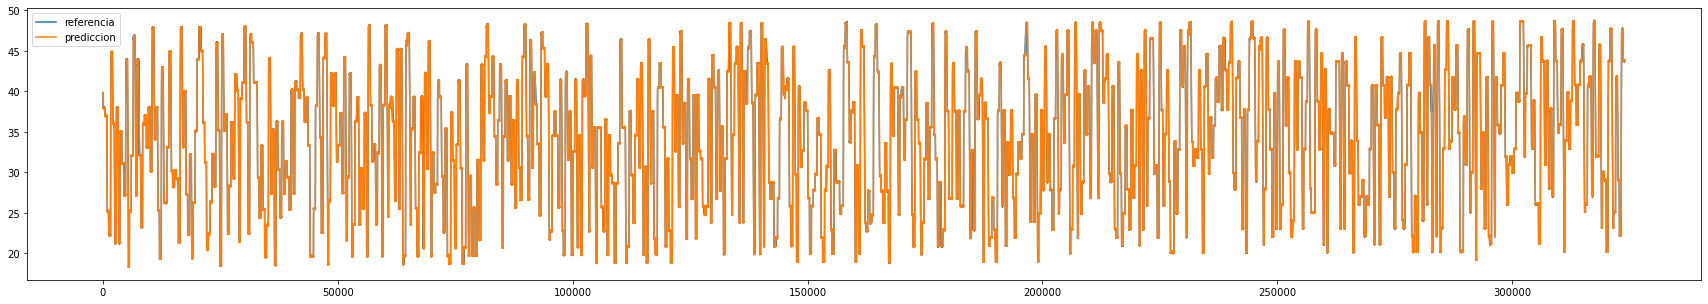

In [277]:
#plot the prediction and referencia
step = 0
plt.figure(figsize=(30,5))
plt.plot(df_exported['tiempo'][step:], df_exported['hc'][step:].shift(0), label='referencia')
plt.plot(df_exported['tiempo'][step:], pd.Series(y_hat).shift(0), label='prediccion')
plt.legend()
# plt.xlim(36000+3600*6, 36100+3600*6)

#TODO SATMODELS ARMODEL
#V. EXOGENAS.


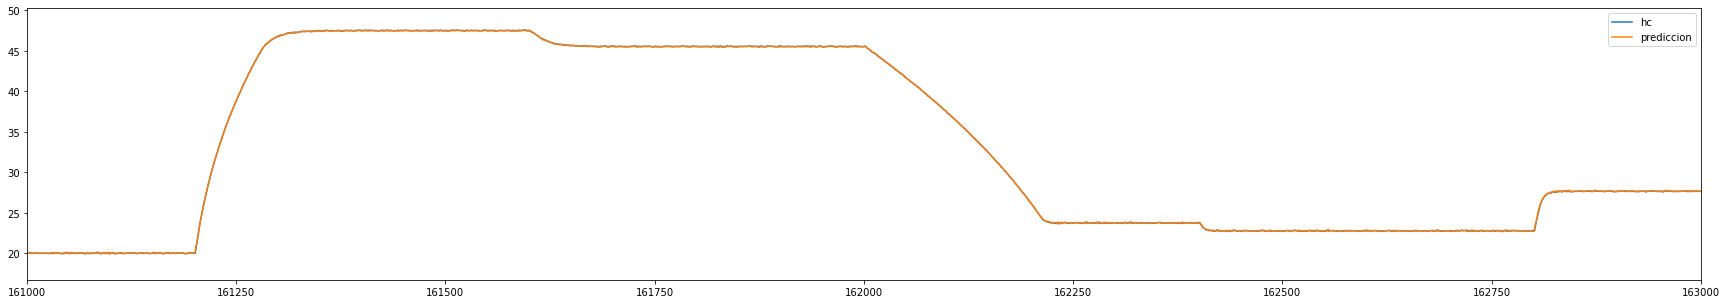

In [280]:
# snapshot of the interval [1000-1100]
step=0
plt.figure(figsize=(30,5))
plt.plot(df_exported['tiempo'][step:], df_exported['hc'][step:].shift(0), label='hc')
plt.plot(df_exported['tiempo'][step:], y_hat, label='prediccion')
i=20
# plt.xlim(50000, 54000)
plt.xlim(161000, 163000)
# plt.ylim(5, 25)
plt.legend()


In [1101]:
step

15

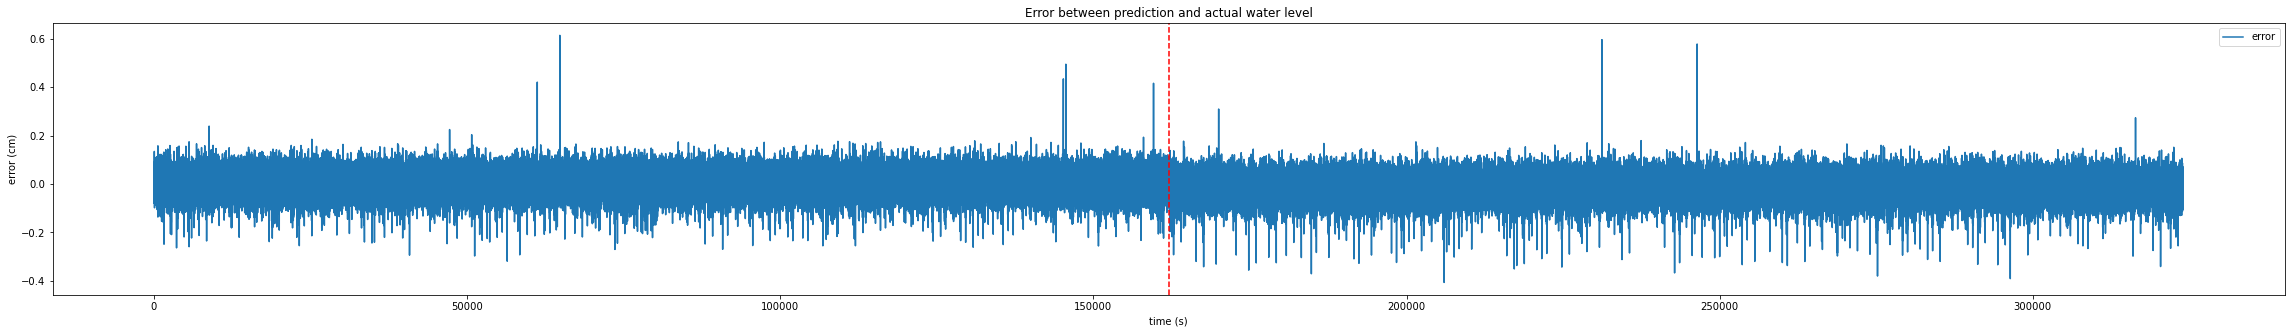

In [281]:
#plot error between prediction and actual hc
step = 0
plt.figure(figsize=(40,5))
plt.plot(df_exported['tiempo'][step:], -(y_hat - df_exported['hc'][step:].shift(0)).rolling(int(1)).mean(), label='error')
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('error (cm)')
plt.title('Error between prediction and actual water level')
plt.axvline(x=162000, color='r', linestyle='--')

# plt.xlim(72000, 73000)
plt.show()


In [840]:
step = 2
error = -(y_hat - df['hc'][step:].shift(0))
#add awgn to error
# error = error + np.random.normal(0, 0.5, len(error))


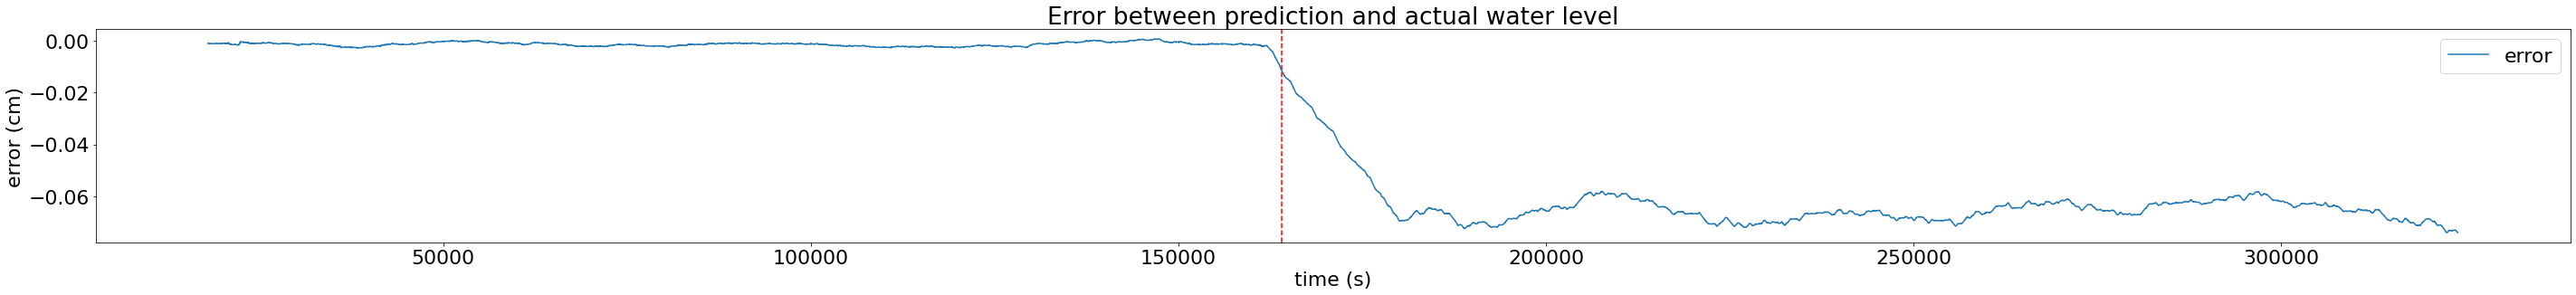

In [842]:
plt.figure(figsize=(40,5))
plt.plot(df['tiempo'][step:], error.rolling(3600).mean(), label='error')
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('error (cm)')
plt.title('Error between prediction and actual water level')
plt.axvline(x=164000, color='r', linestyle='--')

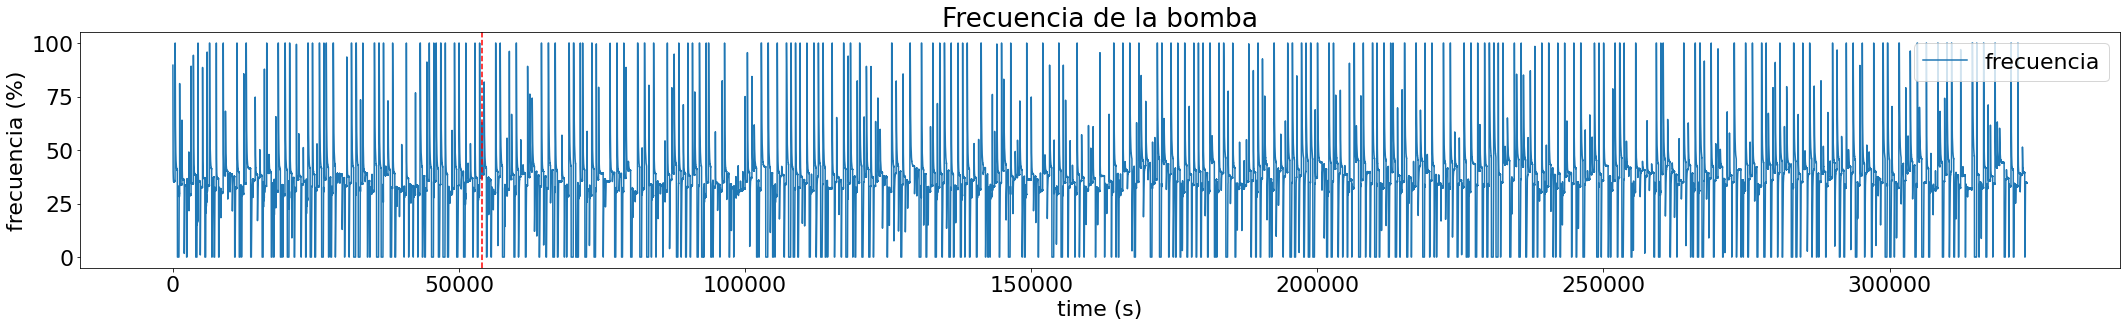

In [843]:
#plot frequency
plt.figure(figsize=(30,5))
plt.plot(df['tiempo'][step:], df['f_pid'][step:].shift(0).rolling(1).mean(), label='frecuencia')
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('frecuencia (%)')
plt.title('Frecuencia de la bomba')
#draw a line at x = 36000
plt.axvline(x=54000, color='r', linestyle='--')
plt.show()


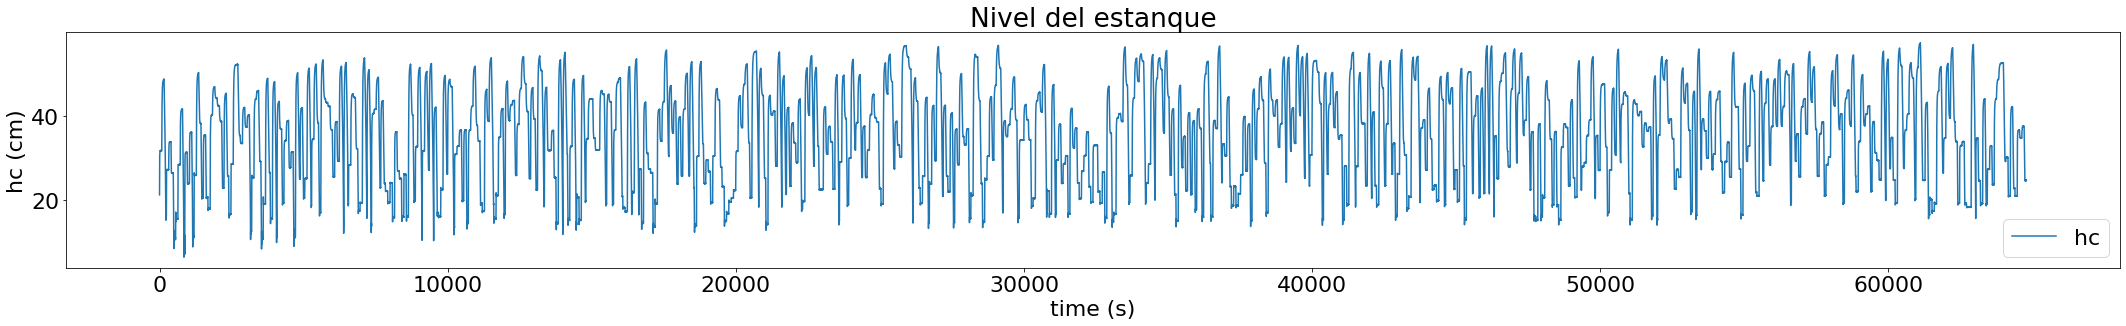

In [844]:
#plot hc
plt.figure(figsize=(30,5))
plt.plot(pd.Series(y_hat).rolling(1).mean(), label='hc')
plt.rcParams.update({'font.size': 22})
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('hc (cm)')
#resize font
plt.title('Nivel del estanque')
plt.show()


In [212]:
y_hat

array([38.384197, 41.526237, 40.104355, ..., 42.456444, 42.42034 ,
       42.42713 ], dtype=float32)

In [226]:
df['hc'][2:]

37        38.348897
55        41.609493
73        40.052268
91        38.449192
109       36.774452
            ...    
179911    42.318991
179929    42.341481
179947    42.299797
179965    42.310836
179983    42.294526
Name: hc, Length: 9998, dtype: float64

In [266]:
#calculate hc dot
df['hc_dot'] = df['hc'].diff(1)



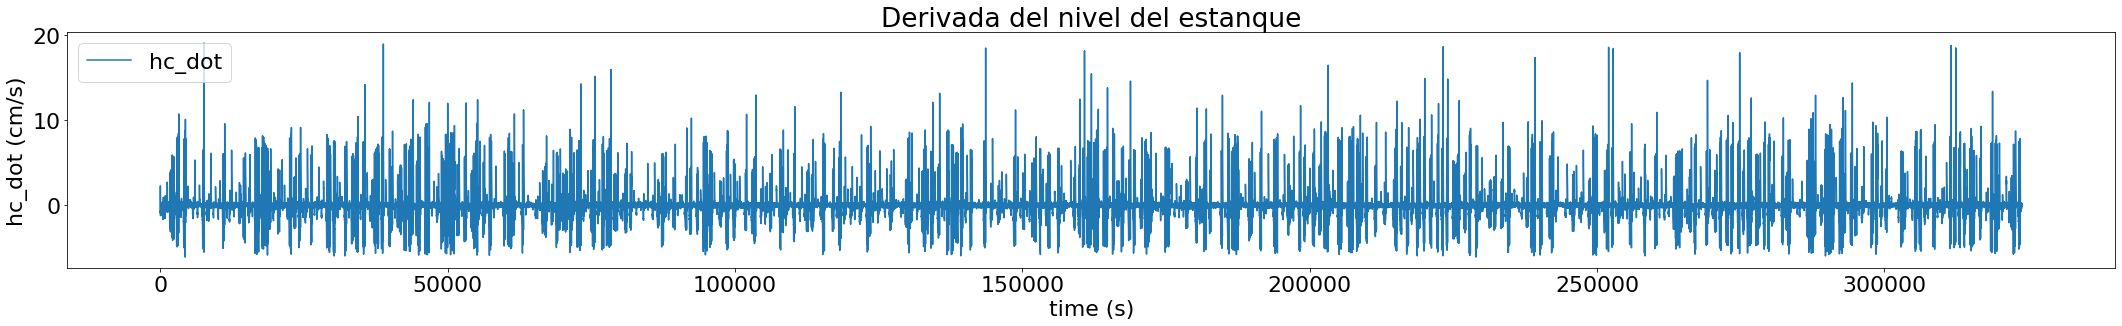

In [267]:
#plot hc_dot
step = 2
plt.figure(figsize=(30,5))
plt.plot(df['tiempo'][step:], df['hc_dot'][step:].shift(0).rolling(1).mean(), label='hc_dot')
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('hc_dot (cm/s)')
plt.title('Derivada del nivel del estanque')
plt.show()


In [716]:
len(error)

32398

In [717]:
90/5

18.0

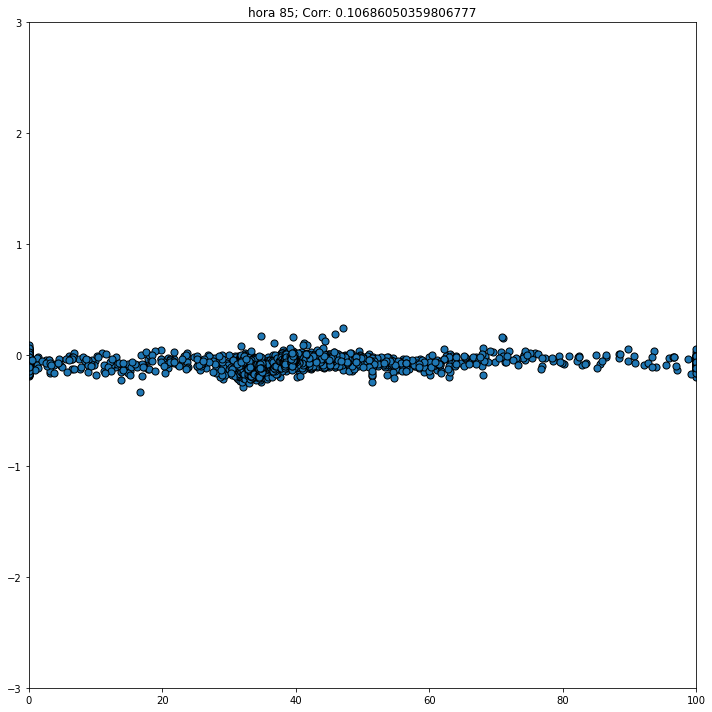

In [852]:
import matplotlib.animation as animation

plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["figure.autolayout"] = True
e_s = []
y_s = []
corrs = []
step = 5
steps = 18

for i in range(steps):
    window = int(3600*5/step)
    #normalize h
    #normalize error
    # error_norm = ((y_hat - df['hc'][step:]).rolling(window).mean() - (y_hat - df['hc'][step:]).rolling(window).mean().min())/( (y_hat - df['hc'][step:]).rolling(window).mean().max() - (y_hat - df['hc'][step:]).rolling(window).mean().min())
    start = int(3600*5*i/step)
    
    error_plot = error.rolling(1).mean()[start:start+window]#(y_hat - df['hc'][2:].shift(0))[start:start+window]
    hc_plot = df['f_pid'][2:].shift(2).rolling(1).mean()[start:start+window]
    
    corr = np.corrcoef(hc_plot[1:], error_plot[1:])[0,1]
    corrs.append(corr)

    e_s.append(error_plot)
    y_s.append(hc_plot)

fig, ax = plt.subplots()
marker_size = 50

def animate(i):
   fig.clear()
   ax = fig.add_subplot(111, autoscale_on=False, xlim=(0, 100), ylim=(-3, 3))
   ax.set_xlim(0, 100)
   ax.set_ylim(-3, 3)
   ax.set_title(f'hora {5*i}; Corr: ' + str(corrs[i]))
   s = ax.scatter(y_s[i], e_s[i],s=marker_size, cmap="RdBu_r", marker="o", edgecolor='black')

plt.grid(visible=None)
ani = animation.FuncAnimation(fig, animate, interval=800, frames=range(steps))

ani.save(f'../gifs/animation_{str(step)}s_no10m1_st_10s_10a_fpid.gif', writer='pillow')

In [1564]:
960*15/3600

4.0

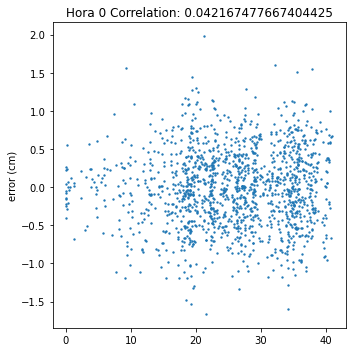

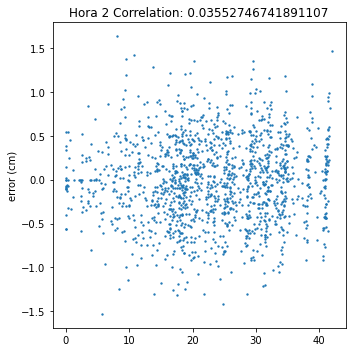

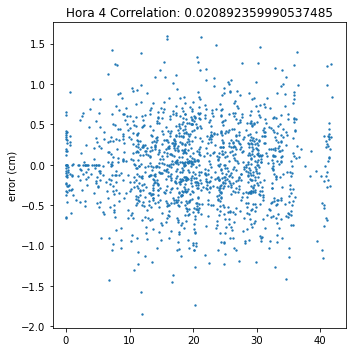

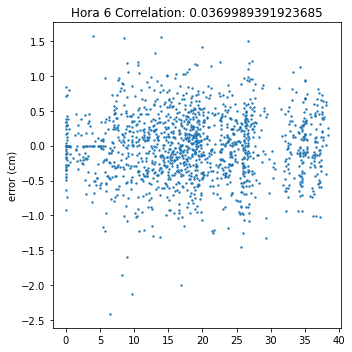

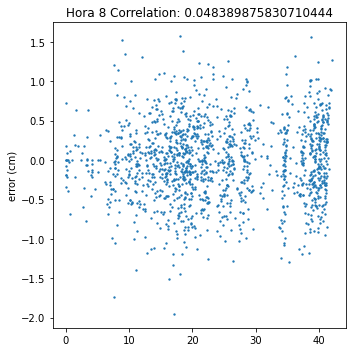

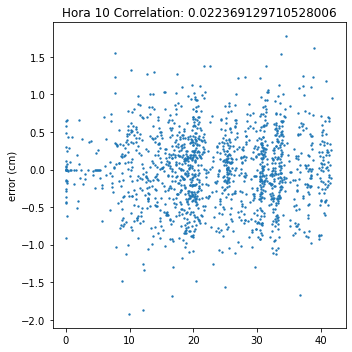

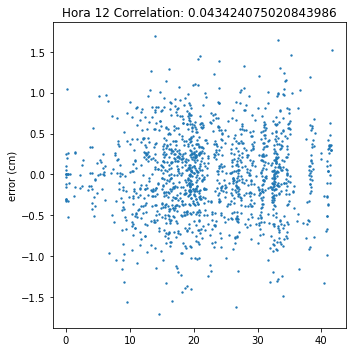

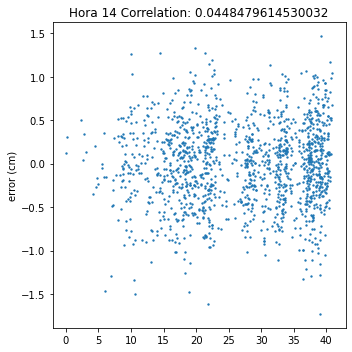

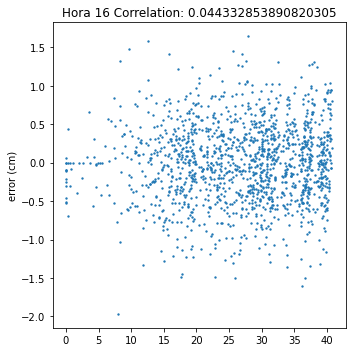

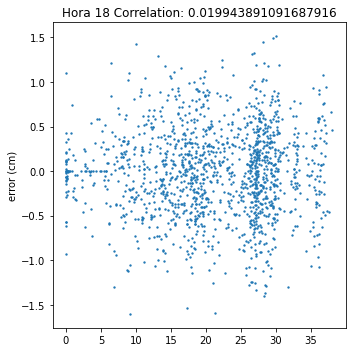

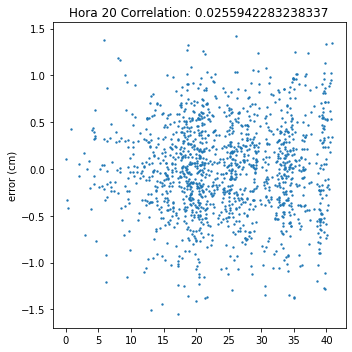

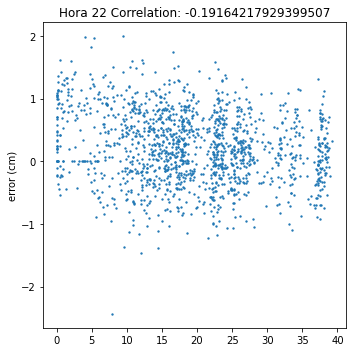

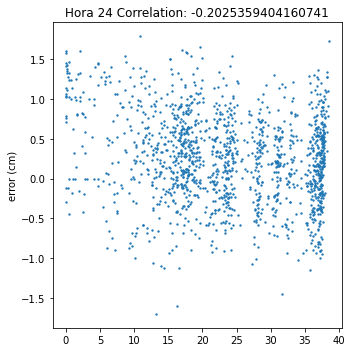

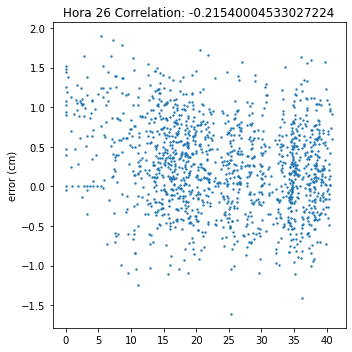

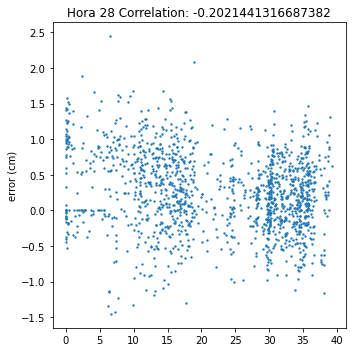

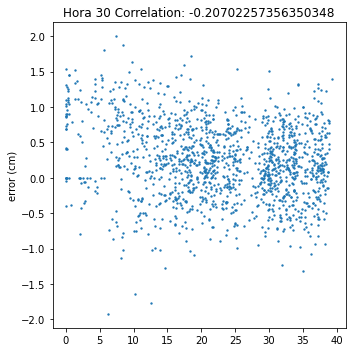

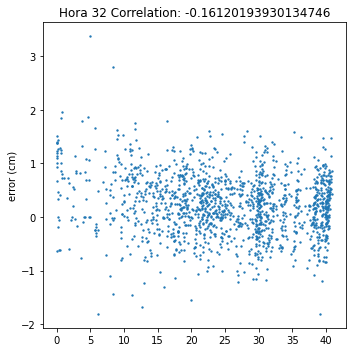

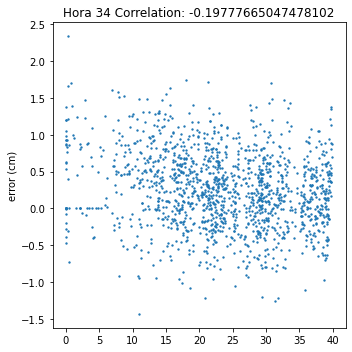

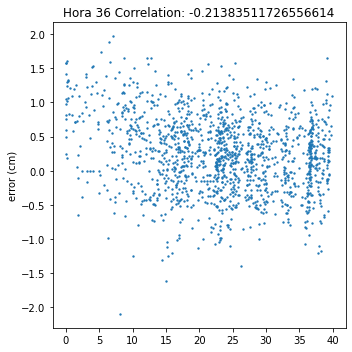

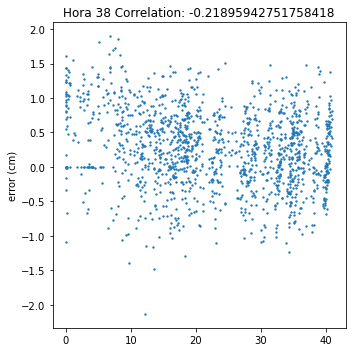

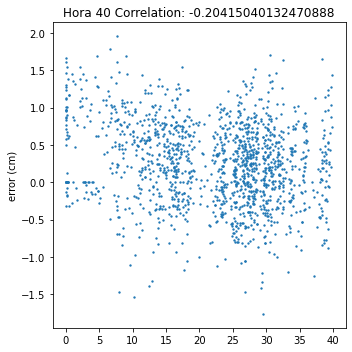

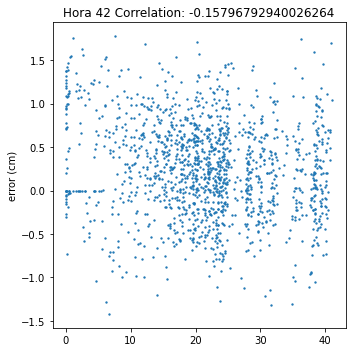

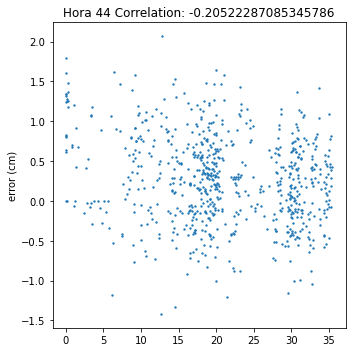

c:\ProgramData\Anaconda3\envs\obsolescence\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\ProgramData\Anaconda3\envs\obsolescence\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
c:\ProgramData\Anaconda3\envs\obsolescence\lib\site-packages\numpy\lib\function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\ProgramData\Anaconda3\envs\obsolescence\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
c:\ProgramData\Anaconda3\envs\obsolescence\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


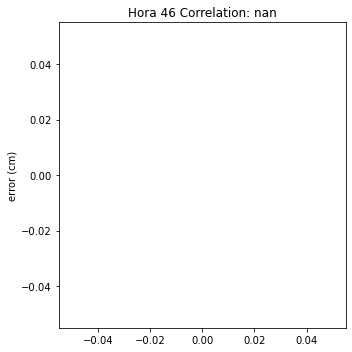

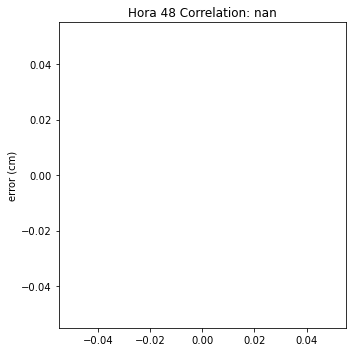

In [707]:
#dinamic scatter plot of the error vs actual hc
corrs = []
step = 5
for i in range(25):
    window = int(3600*2/step)
    #normalize hc
    #normalize error
    # error_norm = ((y_hat - df['hc'][step:]).rolling(window).mean() - (y_hat - df['hc'][step:]).rolling(window).mean().min())/( (y_hat - df['hc'][step:]).rolling(window).mean().max() - (y_hat - df['hc'][step:]).rolling(window).mean().min())
    start = int(3600*2*i/step)
    plt.figure(figsize=(5,5))
    plt.rcParams.update({'font.size': 10})
    error_plot = (y_hat - df['hc'][2:].shift(0))[start:start+window]
    hc_plot = ((df['hc'][2:]).shift(1)[start:start+window])
    plt.scatter(hc_plot, error_plot, alpha=0.9,s=2)
    # plt.scatter(hc_norm[:window], error_norm[:window], s=10)
    #resize font
    #estimate correlation
    corr = np.corrcoef(hc_plot[1:], error_plot[1:])[0,1]
    corrs.append(corr)
    plt.title(f'Hora {i*2} Correlation: ' + str(corr))
    # plt.xlabel('f_pid (Hz)')
    plt.ylabel('error (cm)')
    # plt.title('Error vs actual water level')
    # plt.xlim(0,50)
    # # plt.ylim(-10,10)
    plt.show()


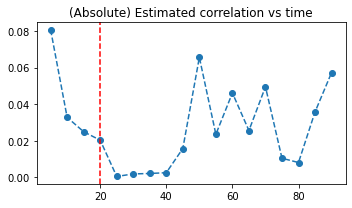

In [851]:
x = np.linspace(5, 90,18)
plt.figure(figsize=(5,3))
plt.rcParams.update({'font.size': 10})
plt.plot(x, np.abs(corrs), label='correlation', linestyle='--', marker='o')
plt.title('(Absolute) Estimated correlation vs time')
plt.axvline(x=20, color='r', linestyle='--')

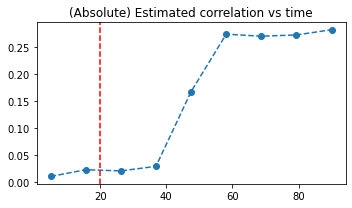

In [724]:
x = np.linspace(5, 90,9)
plt.figure(figsize=(5,3))
plt.rcParams.update({'font.size': 10})
plt.plot(x, np.abs(corrs), label='correlation', linestyle='--', marker='o')
plt.title('(Absolute) Estimated correlation vs time')
plt.axvline(x=20, color='r', linestyle='--')

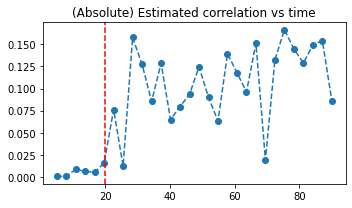

In [360]:
x = np.linspace(5, 90,30)
plt.figure(figsize=(5,3))
plt.rcParams.update({'font.size': 10})
plt.plot(x, np.abs(corrs), label='correlation', linestyle='--', marker='o')
plt.title('(Absolute) Estimated correlation vs time')
plt.axvline(x=20, color='r', linestyle='--')

In [1356]:
df[:][2:]

tiempo  referencia         hc      f_pid    hc_dot
20          20          40  29.132417  32.832530  4.132416
30          30          40  28.774452  23.279197 -0.357964
40          40          40  27.640519  23.432146 -1.133934
50          50          40  27.716343  27.011174  0.075824
60          60          40  27.450692  27.920567 -0.265651
...        ...         ...        ...        ...       ...
179960  179960          20  19.889155  43.578447  0.066337
179970  179970          20  19.971251  44.319729  0.082096
179980  179980          20  19.864492  43.161825 -0.106760
179990  179990          20  20.179165  43.966696  0.314674
180000  180000           1  21.179529  43.822767  1.000364

[17999 rows x 5 columns]

In [609]:
#export csv with y_hat
df_export = df[:][2:].copy()
df_export['y_hat'] = y_hat
df_export.to_csv('../outputs modelo/new/out_no10m2_fp10b_st5s.csv', index=False)



# OLD

In [ ]:
#dinamic scatter plot of the error vs actual hc
step = 5
window = int(3600*1/step)
start = int(3600*10/step+100)



plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 10})
error_plot = (pd.Series(y_hat[::step]).diff(1) - pd.Series(df['hc'][::step].shift(1)).diff(1).reset_index(drop=True))[start:start+window]
hc_plot = ((df['hc'][::step]).shift(1)[start:start+window])
plt.scatter(hc_plot, error_plot, alpha=0.5,s=1)

plt.title('Correlation: ' + str(np.corrcoef(hc_plot[:window], error_plot[:window])[0,1]))
plt.ylabel('error (cm)')
plt.show()

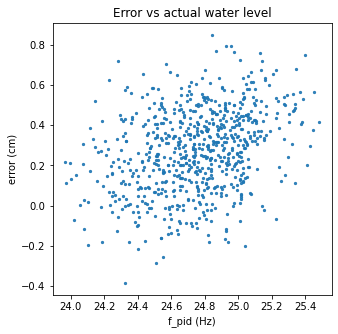

In [599]:
#dinamic scatter plot of the error vs actual hc
step = 5
window = int(3600*1/step)
#normalize hc
#normalize error
# error_norm = ((y_hat - df['hc'][step:]).rolling(window).mean() - (y_hat - df['hc'][step:]).rolling(window).mean().min())/( (y_hat - df['hc'][step:]).rolling(window).mean().max() - (y_hat - df['hc'][step:]).rolling(window).mean().min())
start = int(3600*30/step)
plt.figure(figsize=(5,5))
plt.scatter((df['hc'][::step].shift(1)[start:start+window]), (y_hat[::step] - df['hc'][::step].shift(0))[start:start+window], alpha=0.9,s=5)
# plt.scatter(hc_norm[:window], error_norm[:window], s=10)
#resize font
plt.xlabel('f_pid (Hz)')
plt.ylabel('error (cm)')
plt.title('Error vs actual water level')
# plt.rcParams.update({'font.size': 10})
plt.show()

In [610]:
#export dataframe with y_hat
df['y_hat'] = y_hat
df.to_csv('../outputs modelo/new/df.csv')


## TESTEO EN FALLA

In [189]:
# model = MLP()
# model.load_state_dict(torch.load('../modelos torch/model_tanque_referencia_fija_5s.pt'))
# model.to(device)

In [235]:
#test with another set of data

failure_location = "bomba"
data_version = "_referencia_fija_5s"

# df_2 = pd.read_csv(f'../datos estanque/datos con falla/data_falla_incipiente_{failure_location}{data_version}.csv')
df_2 = pd.read_csv('../datos estanque/datos con falla/falla_fuga_t5s_noint.csv') #pd.read_csv(f'../datos estanque/datos con falla/data_falla_incipiente_{failure_location}{data_version}.csv')



#create df_test sampling every 1 seconds (or trained MPL model sampling time):

df_test = df_2.iloc[::5].copy()
df_test.head()


tiempo  referencia         hc  f_pid  predicted_hc
0        0          25   0.000001    0.0      0.000001
5        5          25   0.133704    0.0      0.000001
10      10          25  14.339352  100.0     14.213493
15      15          25  19.119719  100.0     19.181627
20      20          25  22.630966  100.0     22.678623

In [236]:
#create hc_prev same as previous

#create a new column with the previous value of hc
df_test['hc_prev'] = df_test['hc'].shift(1)

df_test['hc_prev_prev'] = df_test['hc_prev'].shift(1)
df_test['hc_prev_3'] = df_test['hc_prev_prev'].shift(1)
df_test['hc_prev_4'] = df_test['hc_prev_3'].shift(1)


df_test['freq_prev'] = df_test['f_pid'].shift(1)
df_test['freq_prev_prev'] = df_test['freq_prev'].shift(1)
df_test['freq_prev_3'] = df_test['freq_prev_prev'].shift(1)
df_test['freq_prev_4'] = df_test['freq_prev_3'].shift(1)

In [237]:
#create X_test_1 and y_test_1:
X_test_1 = torch.from_numpy(np.vstack(((df_test['hc_prev'].to_numpy(),
                                     df_test['hc_prev_prev'].to_numpy(),
                                     
                                     df_test['f_pid'].to_numpy(),
                                     df_test['freq_prev'].to_numpy(),
                                     ))).T).float()

X_test_1 = X_test_1.to(device)

y_test_1 = torch.from_numpy(((df_test['hc'].to_numpy()))).float()
y_test_1 = y_test_1.to(device)


In [238]:
#create y_hat
y_hat_1 = model(X_test_1.unsqueeze(1))
y_hat_1 = y_hat_1.squeeze().detach().cpu().numpy()
y_test_1 = y_test_1.detach().cpu().numpy()


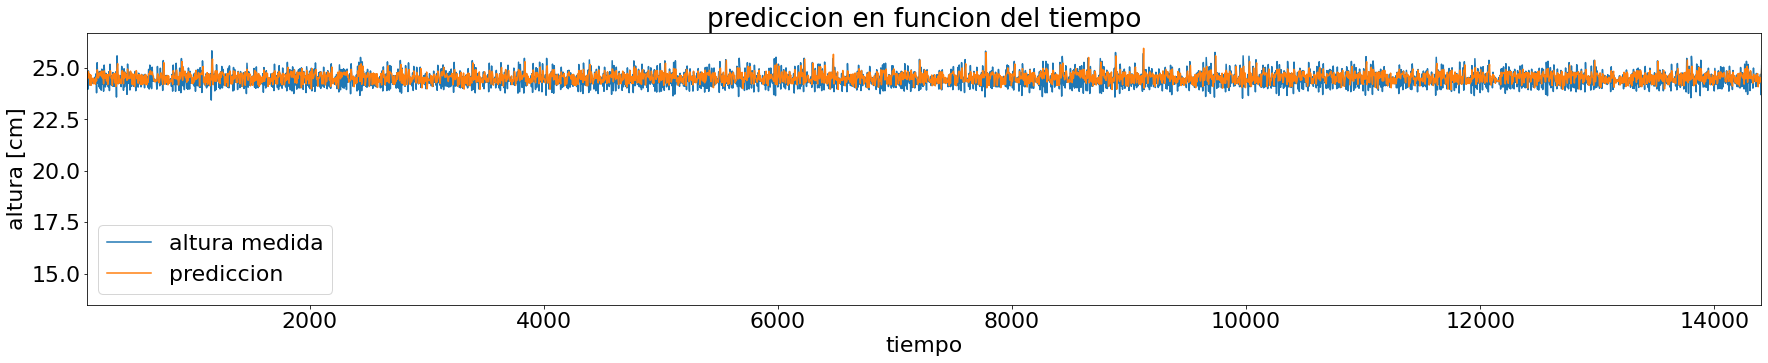

In [244]:
#plot prediction and reference
plt.figure(figsize=(30,5))
plt.plot(df_test['tiempo'][4:], df_test['hc'][4:], label='altura medida')
plt.plot(df_test['tiempo'], y_hat_1, label='prediccion')
# plt.plot(df_test['tiempo'], df_test['predicted_hc'], label='prediccion')
# plt.plot(df_test['tiempo'][4:], df_test['f_pid'][4:])
plt.legend()
plt.xlabel('tiempo')
plt.ylabel('altura [cm]')
plt.title('prediccion en funcion del tiempo')
plt.legend()
#draw vertical line in x = 3600
plt.axvline(x=36000, color='red', linestyle='--')
plt.xlim(100,len(df_test))

plt.show()


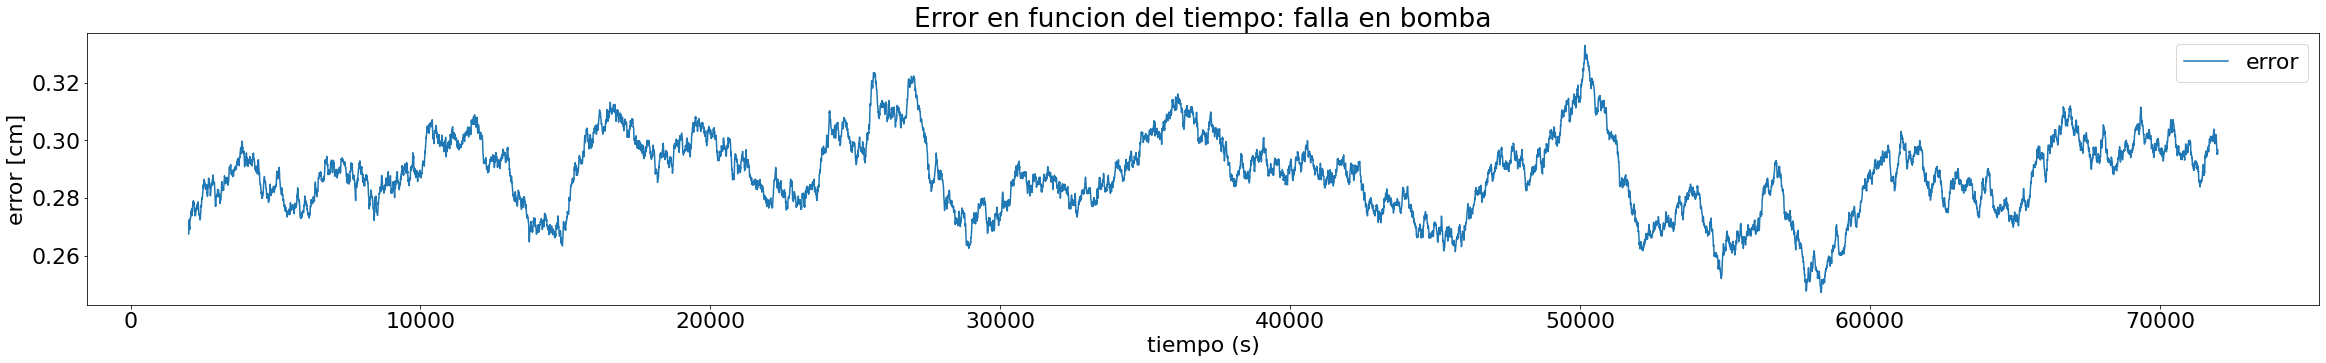

In [245]:
#plot error between prediction and reference
plt.figure(figsize=(40,5))
plt.plot(df_test['tiempo'], abs(y_hat_1 - df_test['hc']).rolling(400).mean(), label='error')
plt.xlabel('tiempo (s)')
plt.ylabel('error [cm]')
plt.title(f'Error en funcion del tiempo: falla en {failure_location}')
# # draw vertical line in x = 3600 and 7200
# plt.axvline(x=36000, color='green', linestyle='--', label='inicio falla')
# plt.axvline(x=36000+3600, color='blue', linestyle='--', label='falla a 1 hora')
# plt.axvline(x=36000+2*3600, color='orange', linestyle='--', label='falla a 2 horas')
# plt.axvline(x=36000+5*3600, color='red', linestyle='--', label='falla a 5 horas')
plt.legend()

plt.show()

In [242]:

#add y_hat_1 to df_test
df_test['y_hat_1'] = y_hat
df_test['error'] =  (df_test['hc'] - df_test['y_hat_1'])

#export df_test to csv
df_test.to_csv('..\outputs modelo\csv\out_sin_falla_t_continuo.csv')#f'..\outputs modelo\csv\out_falla_{failure_location}{data_version}.csv', index=False)

ValueError: Length of values (28801) does not match length of index (14401)

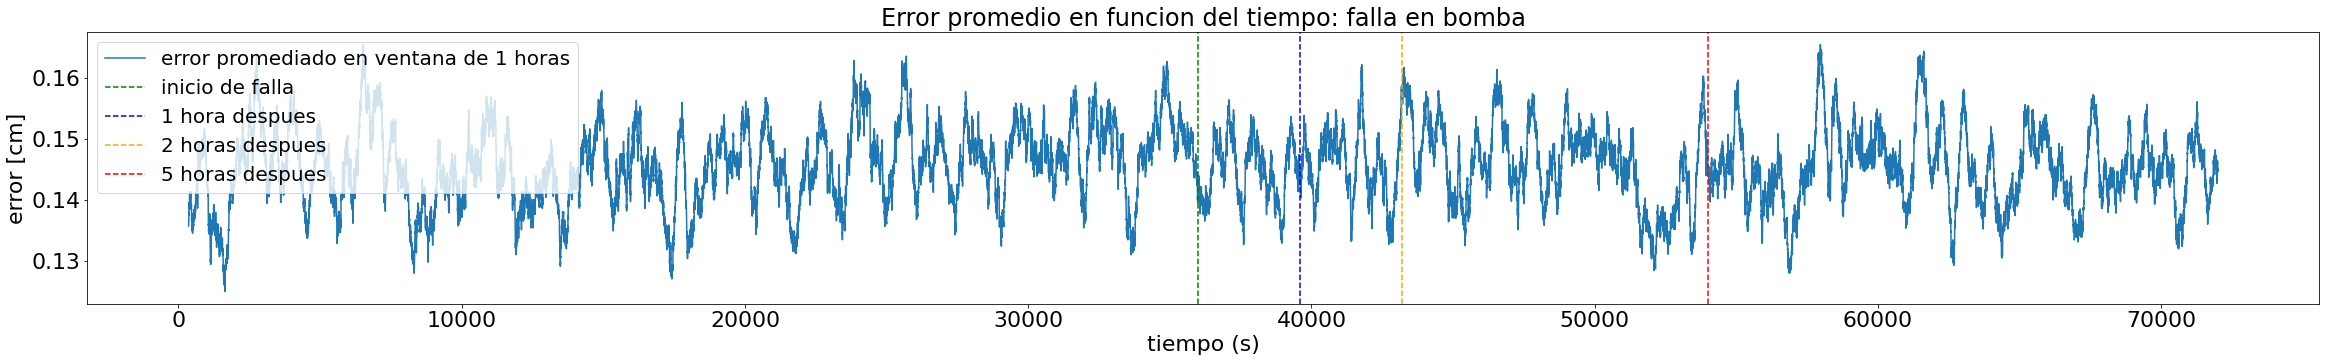

In [165]:
#plot mean error in a window of H hours sampling time

H = 1 #hours

plt.figure(figsize=(40,5))
# plt.plot(df_test['tiempo'], df_test['y_hat_1'] - df_test['hc'], label='error')
plt.plot(df_test['tiempo'],(abs(df_test['y_hat_1'] - df_test['hc'])).rolling(int(3600/10*H)).mean(), label=f'error promediado en ventana de {H} horas')
plt.rcParams.update({'font.size': 20})
plt.legend()
plt.xlabel('tiempo (s)')
plt.ylabel('error [cm]')
plt.title(f'Error promedio en funcion del tiempo: falla en {failure_location}')
# draw vertical line in x = 3600 and 7200
plt.axvline(x=36000, color='green', linestyle='--', label='inicio de falla')
plt.axvline(x=36000+3600, color='blue', linestyle='--', label='1 hora despues')
plt.axvline(x=36000+2*3600, color='orange', linestyle='--', label='2 horas despues')
plt.axvline(x=36000+5*3600, color='red', linestyle='--', label='5 horas despues')
plt.legend()
plt.show()


In [130]:
#save every column of df_test to numpy array
import os
failure_location = "fuga"
data_version =  "referencia_fija"
to_save = pd.read_csv(f'../outputs modelo/csv/out_falla_{failure_location}{data_version}.csv')

#create new directory to save numpy arrays
os.mkdir(f'../outputs modelo/npy/falla_{failure_location}{data_version}')

used_columns = ['tiempo', 'hc', 'f_pid', 'hc_prev', 'hc_prev_prev', 'freq_prev', 'y_hat_1', 'error']

for column in used_columns:
    np.save(f'../outputs modelo/npy/falla_{failure_location}{data_version}/{column}.npy', df_test[column].to_numpy())

## MODELO GENERADO POR EL SIMULINK

In [313]:
model_slx = pd.read_csv('../datos estanque/datos con falla/falla_fout_grave_t4s_long_v3.csv')[0:][::5]

model_slx.head()


tiempo  referencia         hc      f_pid  predicted_hc
0        0          25   0.000001   0.000000      0.000001
5        5          25   0.164789   0.000000      0.000001
10      10          25   9.627392  56.806237      9.687627
15      15          25  10.657361  31.707123     10.479937
20      20          25  11.177591  34.609529     11.457559

In [314]:
#limit hc to live between 0 and 100
model_slx['hc'] = model_slx['hc'].clip(0,100)


In [315]:
#generate error signal of hc between oracle and model
error_signal = model_slx['hc'] - model_slx['predicted_hc']


Text(0, 0.5, 'error [cm]')

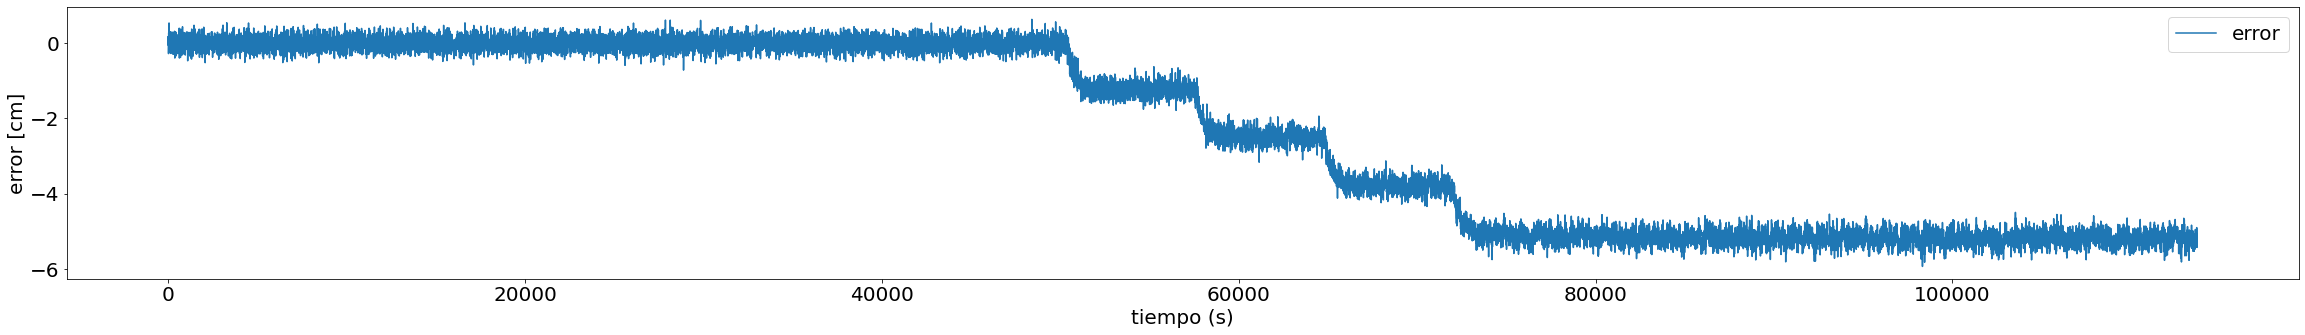

In [316]:
# plot error signal
plt.figure(figsize=(40,5))
plt.plot(model_slx['tiempo'], error_signal ,label='error')
plt.rcParams.update({'font.size': 20})
plt.legend()
plt.xlabel('tiempo (s)')
plt.ylabel('error [cm]')


In [318]:
#calculate derivatives as hc_dot = (hc(t) - hc(t-1))/Ts
hc_dot = np.diff(model_slx['hc'])/5
hc_dot = np.insert(hc_dot, 0, 0)
#add hc_dot to model_slx
model_slx['hc_dot'] = hc_dot


In [319]:
np.insert(np.diff(np.array([1,2,3,4,5,6,7,8,9,10])), 0,0)

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [320]:
#create predicted_hc_dot
predicted_hc_dot = np.diff(model_slx['predicted_hc'])/5
predicted_hc_dot = np.insert(predicted_hc_dot, 0, 0)
#add predicted_hc_dot to model_slx
model_slx['predicted_hc_dot'] = predicted_hc_dot


In [321]:
model_slx.tail(10)

tiempo  referencia         hc      f_pid  predicted_hc    hc_dot  \
113675  113675          25  25.072137  36.909592     30.124018  0.022889   
113680  113680          25  25.137212  37.365082     30.197355  0.013015   
113685  113685          25  24.896285  36.517549     30.245671 -0.048185   
113690  113690          25  25.223128  30.495789     30.121079  0.065368   
113695  113695          25  25.230536  40.400806     30.279227  0.001482   
113700  113700          25  24.888848  36.009556     30.312979 -0.068338   
113705  113705          25  24.705922  28.475171     30.130137 -0.036585   
113710  113710          25  24.797491  30.215548     29.995493  0.018314   
113715  113715          25  24.709499  35.860010     30.025286 -0.017598   
113720  113720          25  24.799893  33.278606     29.981874  0.018079   

        predicted_hc_dot  
113675          0.012129  
113680          0.014667  
113685          0.009663  
113690         -0.024918  
113695          0.031630  
113700          0.006750  
113705         -0.036568  
113710         -0.026929  
113715          0.005959  
113720         -0.008682

In [322]:
#generate same csv as previous with model_slx and error signal
model_slx['error'] = error_signal
# model_slx.to_csv('D:/Desktop/github memoria/modelos-estanque/outputs modelo/csv/out_falla_fout_5s_noint_slx.csv', index=False)


## ESTACIONARIDAD

In [3]:
# read exp_x.csv with x from 1 to 10 as dataframe from datos estanque\estacionaridad\exp_x.csv
dfs = {}
for i in range(1,11):
    dfs[i] = pd.read_csv(f'../datos estanque/estacionaridad/t1s/exp_{i}.csv')
    
 

In [4]:
dfs[10]

tiempo  referencia         hc       f_pid  predicted_hc
0           0          25   0.000001    0.000000      0.000001
1           1          25  -0.002298  100.000000      0.000001
2           2          25   6.545464  100.000000      6.454067
3           3          25   9.043319  100.000000      9.250927
4           4          25  11.298538  100.000000     11.248088
...       ...         ...        ...         ...           ...
35996   35996          25  24.980395    3.076255     24.684718
35997   35997          25  24.580731   45.940282     24.542286
35998   35998          25  24.465235   58.327229     24.634464
35999   35999          25  24.890010   12.770112     24.831272
36000   36000          25  24.700439   33.101686     24.701998

[36001 rows x 5 columns]

In [6]:
# a_1 = 5.43
# a_2 = -78.23
# b = 20.21

# #calculate F_in and F_out
# for i in range(1,11):
#     dfs[i]['F_in'] = a_1*dfs[i]['hc'] + a_2*dfs[i]['hc'] + b*dfs[i]['f_pid']
#     dfs[i]['F_out'] = dfs[i]['F_in'] - dfs[i]['F']

In [41]:
tau = 36000-3600
t = 0
#calculate empirical corr
empirical_corr = []
for delta in range(0,tau):
    product = []
    for i in range(1,11):
        #normalized product by mean of f_pid
        norm_product = (dfs[i]['f_pid'][t+delta])*(dfs[i]['hc'][tau])
        product.append(norm_product)
    
    empirical_corr.append(np.array(product).sum()/10)


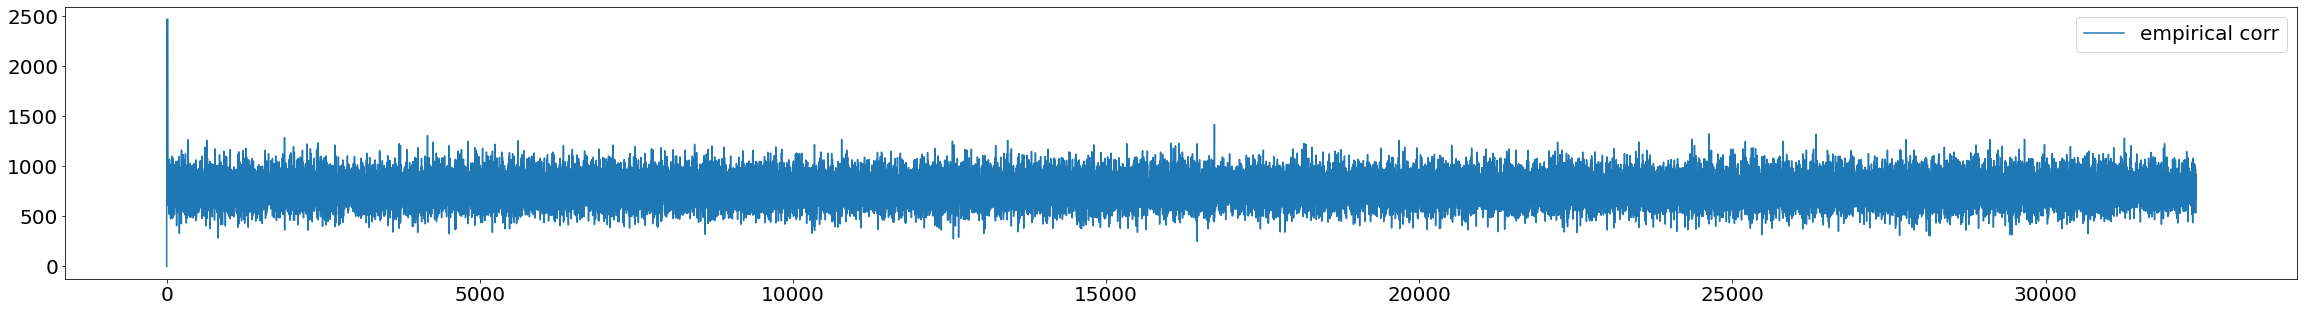

In [42]:
#plot empirical corr
plt.figure(figsize=(40,5))
plt.plot(range(0,tau), empirical_corr, label='empirical corr')
plt.rcParams.update({'font.size': 20})
plt.legend()
plt.show()

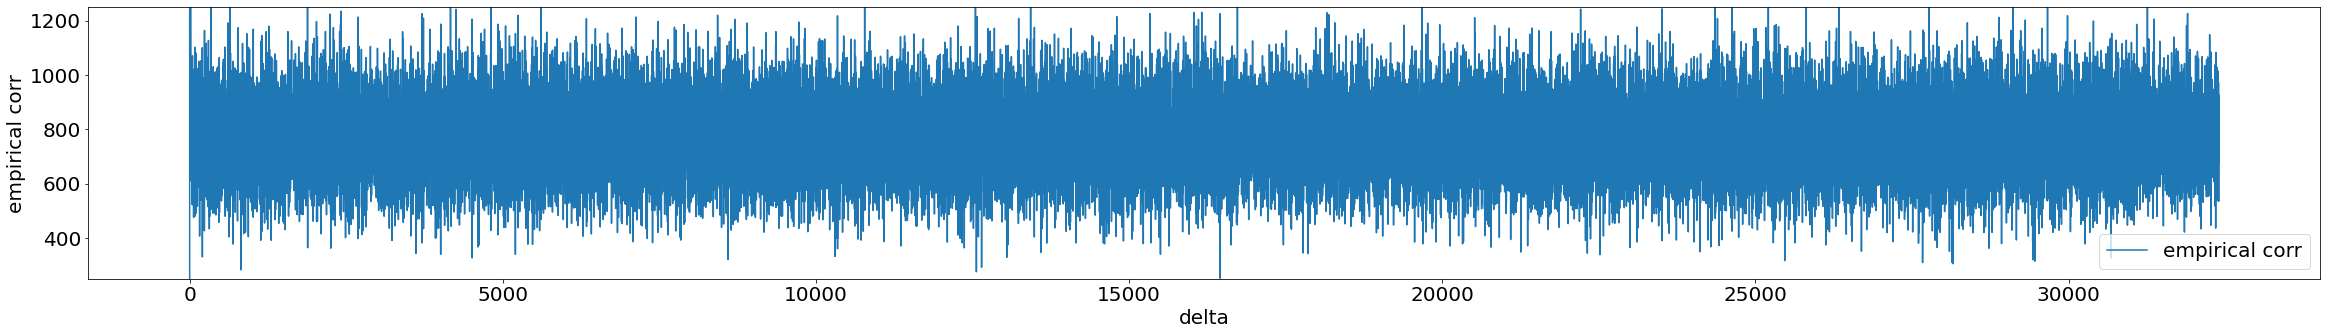

In [46]:
#zoom last graph to see better
plt.figure(figsize=(40,5))
plt.plot(range(0,tau), empirical_corr, label='empirical corr')
plt.ylabel('empirical corr')
plt.xlabel('delta')
plt.rcParams.update({'font.size': 20})
plt.legend()
plt.ylim(250,1250)
plt.show()


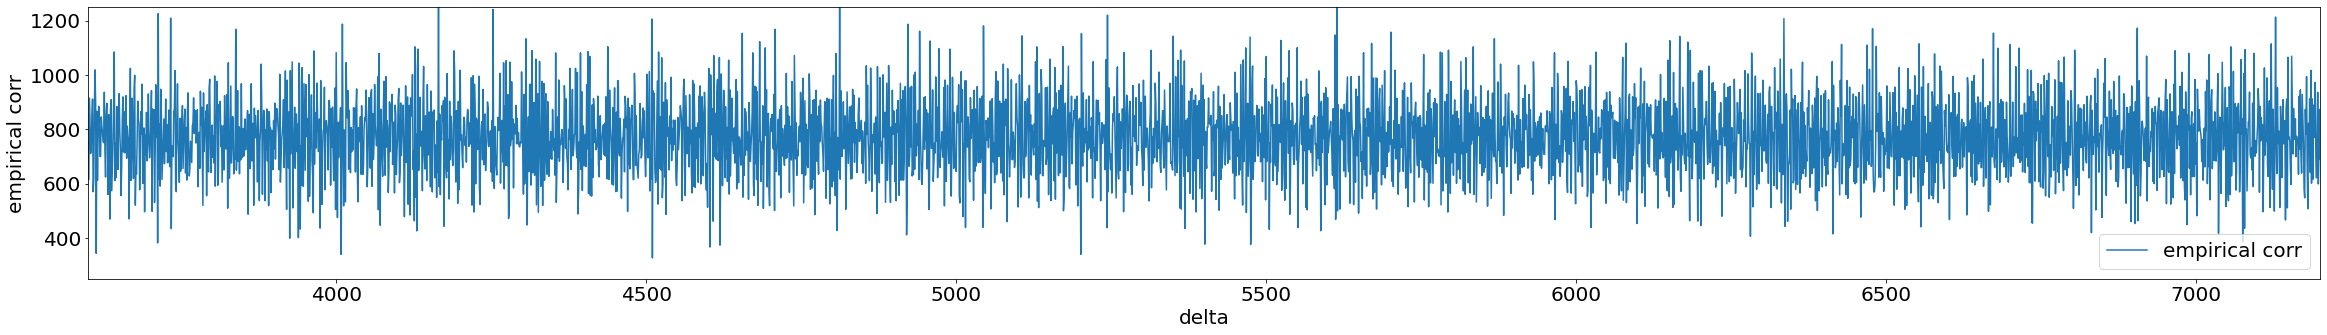

In [47]:
#window of 3600 samples in the prior plot
plt.figure(figsize=(40,5))
plt.plot(range(0,tau), empirical_corr, label='empirical corr')
plt.ylabel('empirical corr')
plt.xlabel('delta')
plt.rcParams.update({'font.size': 20})
plt.legend()
plt.ylim(250,1250)
plt.xlim(3600,7200)
plt.show()


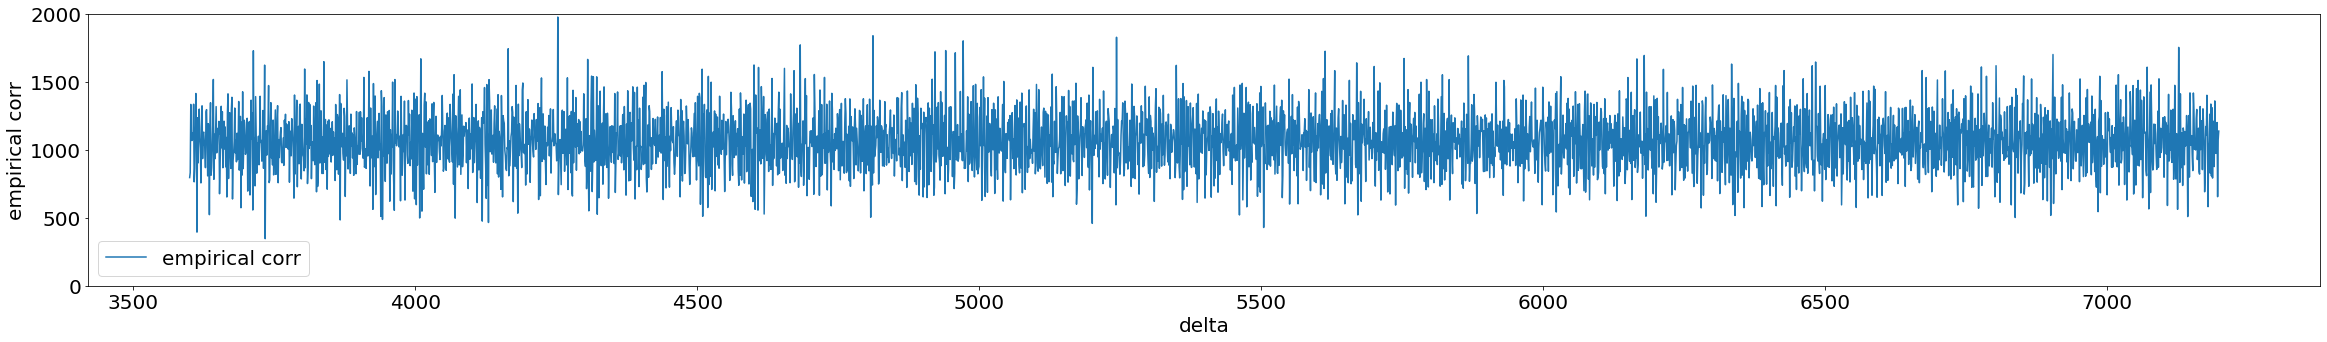

In [33]:
#window of 3600 samples of the prior graph
plt.figure(figsize=(40,5))
plt.plot(range(3600,7200), empirical_corr[3600:7200], label='empirical corr')
plt.ylabel('empirical corr')
plt.xlabel('delta')
plt.rcParams.update({'font.size': 20})
plt.legend()
plt.ylim(0,2000)
plt.show()


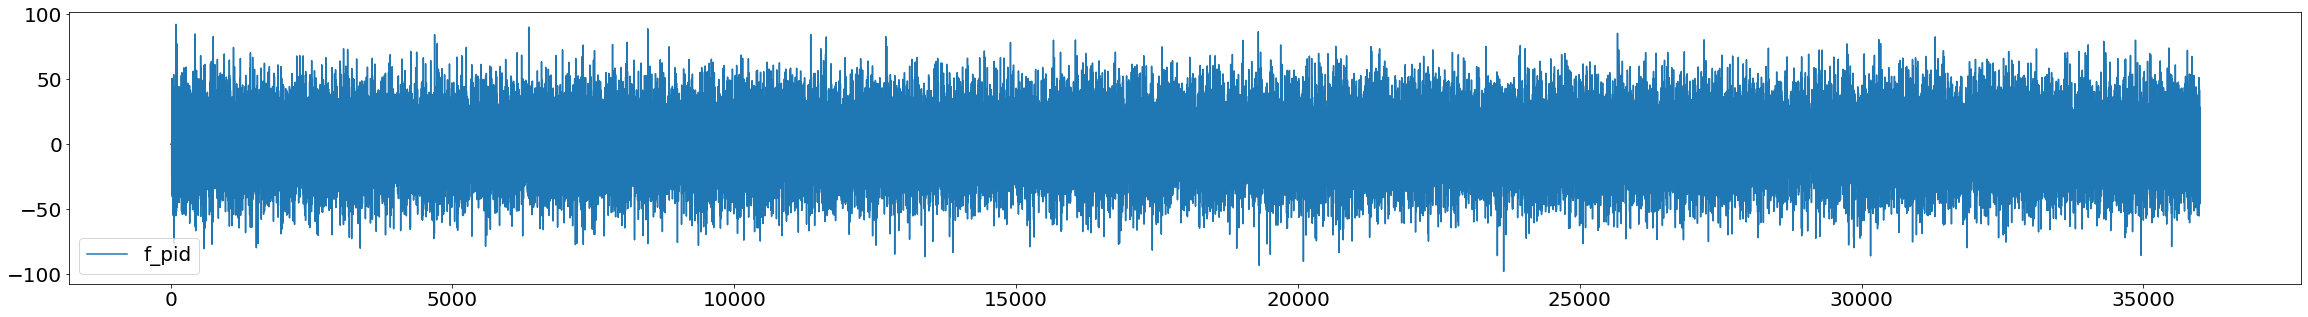

In [304]:
#plot disc variables
plt.figure(figsize=(40,5))
# plt.plot(df_1['tiempo'], disc['hc'], label='hc')
plt.plot(df_1['tiempo'], disc['f_pid'].rolling(1).mean(), label='f_pid')
# plt.plot(df_1['tiempo'], disc['predicted_hc'], label='predicted_hc')
# plt.rcParams.update({'font.size': 20})
plt.legend()

## TIMESERIES ANALYSIS

In [323]:
a_1 = 5.43
a_2 = -78.23
b = 20.21

#limit model_slx[hc] to the interval [0-100]
model_slx['hc'] = model_slx['hc'].clip(0,100)

#calculate F_in and F_out
F_in_hat = a_1*model_slx['f_pid'] + a_2
F_out = b*model_slx['hc']**0.5

F_out_hat = b*model_slx['predicted_hc']**0.5

#add F_in and F_out to model_slx
model_slx['F_in_hat'] = F_in_hat
model_slx['F_out'] = F_out
model_slx['F_out_hat'] = F_out_hat

In [324]:
#generate the residual signal
c1 = 0.63
c2 = 11.4
c3 = 17.1

#predicted f_in = predicted_hc_dot*(c1*predicted_hc**2 + c2*predicted_hc + c3)+predicted_f_out

f_in = model_slx['hc_dot']*(c1*model_slx['hc']**2 + model_slx['hc']*c2 + c3)+model_slx['F_out']
model_slx['F_in'] = f_in


#add residual signal to model_slx only using Fout
residual_signal = model_slx['F_out'] - model_slx['F_out_hat']

#add residual signal to model_slx
model_slx['residual'] = residual_signal


In [326]:
#estimate a1 from F_in 
a1_hat = (model_slx['F_in']-a_2)/model_slx['f_pid']


(-1.0, 100.0)

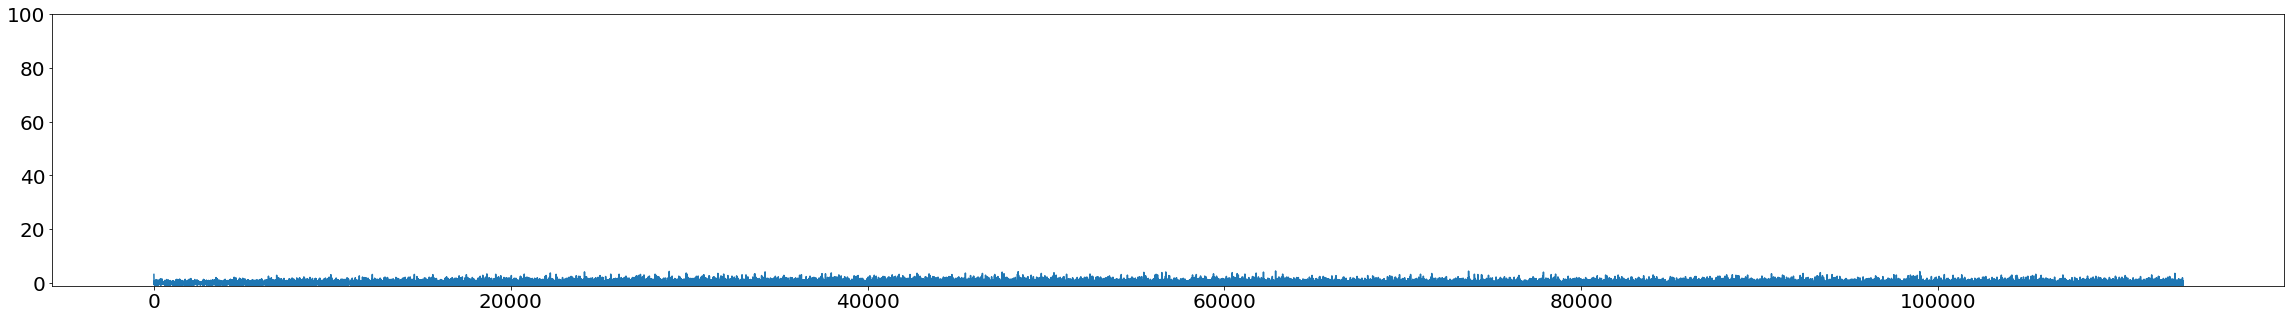

In [327]:
#plot a1_hat - a1
plt.figure(figsize=(40,5))
plt.plot(model_slx['tiempo'], (a1_hat-a_1).rolling(1).mean(), label='a1_hat')
plt.ylim(-1,100)

Text(0.5, 0, 'tiempo (s)')

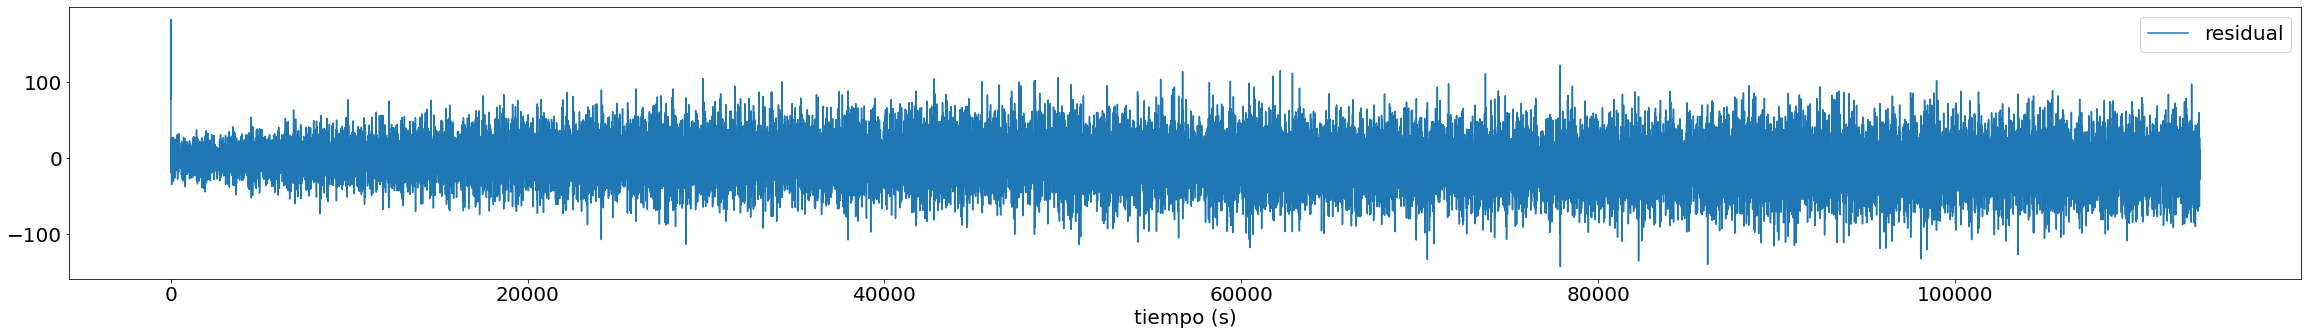

In [328]:
#plot fin - predicted_fin
plt.figure(figsize=(40,5))
plt.plot(model_slx['tiempo'], (model_slx['F_in'] - model_slx['F_in_hat']).rolling(1).mean(), label='residual')
plt.rcParams.update({'font.size': 20})
plt.legend()
# plt.ylim(-0.5,0.5)
plt.xlabel('tiempo (s)')

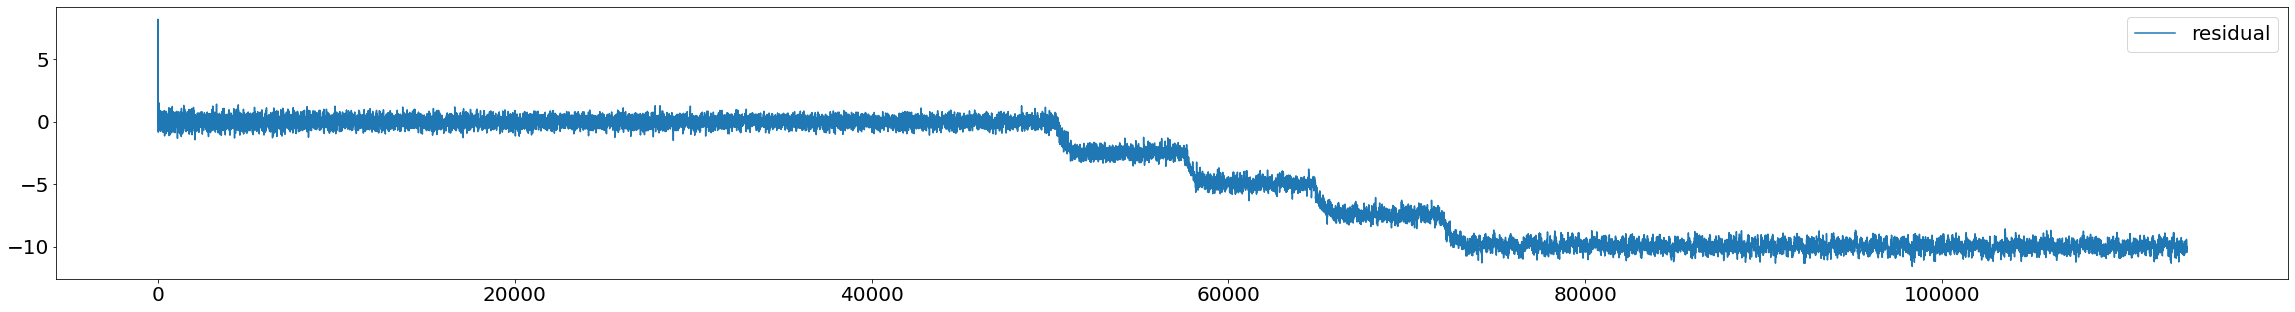

In [330]:
#plot residual signal
plt.figure(figsize=(40,5))
plt.plot(model_slx['tiempo'], model_slx['residual'].rolling(1).mean(), label='residual')
#limit y axis
# plt.ylim(-2,2)
plt.legend()

In [332]:
#extract the first 3600 and last 3600 samples of the residual signal in one dataframe
residual_signal = model_slx['residual'].copy()
residual_signal = residual_signal[0:3600].append(residual_signal[-3600:])

C:\Users\Joaquín\AppData\Local\Temp\ipykernel_21120\3635218094.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  residual_signal = residual_signal[0:3600].append(residual_signal[-3600:])


In [333]:
#export model_slx to csv
model_slx.to_csv('D:/Desktop/github memoria/modelos-estanque/outputs modelo/csv/out_falla_fout_5s_v7_slx.csv', index=False)

In [115]:
rnn = nn.RNN(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
output, hn = rnn(input, h0)

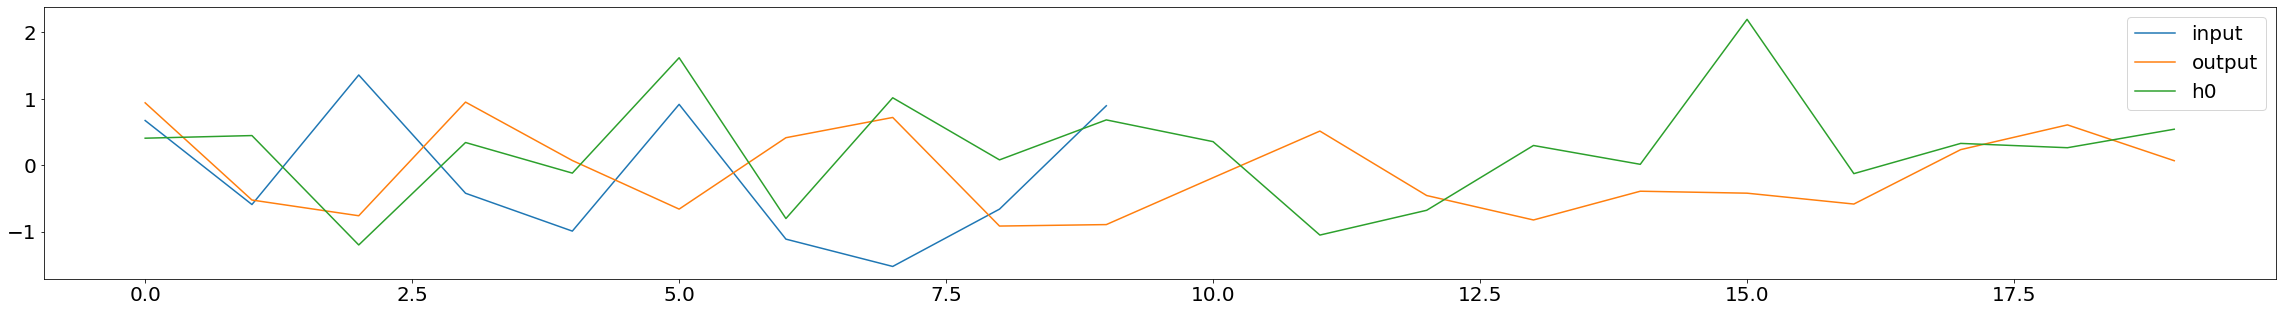

In [126]:
#plot input, h0 and output
plt.figure(figsize=(40,5))
plt.plot(input[0][0].detach().numpy(), label='input')
plt.plot(output[0][0].detach().numpy(), label='output')
plt.plot(h0[0][0].detach().numpy(), label='h0')

plt.legend()
